In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import csv

# Extract `profile.csv` from stats

## Functions

In [2]:
def extract_profile(stats_path, duration, fluctuation_threshold, mode):
    stats = pd.read_csv(stats_path)
    stats_dds = stats[stats['mode'] == mode]
    bandwidth_f1 = stats_dds.sort_values(by=['total-size'])

    # Byte -> bit -> Kbit -> Kbps
    bandwidth_f1['bitrate'] = bandwidth_f1['total-size'] * 8 / 1024 / duration

    # # Remove bad performance fluctuation
    # for index, row in bandwidth_f1.iterrows():

    bandwidth_f1_remove_fluc = bandwidth_f1.copy()

    num_row = bandwidth_f1.shape[0]

    for i in range(1, num_row):
        j = i
        while (bandwidth_f1.iloc[j].F1 - bandwidth_f1.iloc[i-1].F1 < -fluctuation_threshold):
            try:
                bandwidth_f1_remove_fluc = bandwidth_f1_remove_fluc.drop(bandwidth_f1.iloc[j].name)
            except:
                pass
            j += 1
            if (j >= num_row):
                break
    
    return bandwidth_f1_remove_fluc

## Playground

In [3]:
# profile_rene_adaptive = extract_profile("stats",
#                                 4, 0, "emulation-adaptive")
# profile_rene_adaptive_separated = extract_profile("stats",
#                                 4, 0, "emulation-adaptive-separated")

profile_rene_adaptive = extract_profile("stats",
                                4, 0, "emulation-adaptive")
profile_rene_aws = extract_profile("stats",
                                4, 0, "emulation-adaptive-separated")

In [4]:
profile_rene_adaptive

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,bandwidth-limit,mode,bitrate


# Plot profile

In [7]:
profile_rene_adaptive = pd.read_csv("./profile-rene/profile-separated/profile-10.csv")
profile_rene_adaptive
profile_rene_adaptive_aws = pd.read_csv("./profile-rene-aws/profile-separated/profile-10.csv")

0.609

## Functions

In [2]:
def F1_Bandwidth_plot(bandwidth_f1):
    # set figure size
    plt.figure(figsize=(12,6), dpi=80)

    plt.xlabel('Bandwidth (Kbps)')
    plt.ylabel('F1 Score')

    rene = plt.plot(bandwidth_f1['bandwidth'], bandwidth_f1['F1'],
    'o-',
    label = 'Rene-25-3',)

    # y-axis percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    plt.ticklabel_format(style='plain', axis='x', )

    plt.legend()

In [3]:
def calc_profile(profile):
    # create array from this
    lastBW = [profile[i]['bandwidth'].iloc[-1] for i in range(len(profile))]
    maxIdx = lastBW.index(max(lastBW))

    for i in range(len(profile)):
        if i != maxIdx:
            tempF1 = profile[i]['F1'].iloc[-1]
            profile[i] = profile[i].append(profile[maxIdx].iloc[-1], ignore_index=True)
            profile[i]['F1'].iloc[-1] = tempF1
    
    return profile
    
#     plt.figure(figsize=(12,6), dpi=80)

#     plt.xlabel('Bandwidth Limit (Kbps)')
#     plt.ylabel('F1 Score')

#     for i in range(len(profile)):
#         plt1 = plt.plot(profile[i]['bandwidth'], profile[i]['F1'], 'o-', label=labels[i])
#     plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#     plt.ticklabel_format(style='plain', axis='x', )

#     plt.legend()
#     plt.ion()

In [4]:
# profileNum only accepts 1 or even number of profile at this moment(?)
def plot_profile(*profileNum):
    # creating the figure template
    numOfProfiles = len(profileNum)
    row = 0
    col = 0
    if(numOfProfiles == 1):
        row = 1
        col = 1
    else:
        row = numOfProfiles//2
        col = 2
    
    
    # calculate all of the sensitivities
    profiles = []
    labels = []
#     dataset = ["highway", "jakarta", "roppongi", "coldwater", "jakarta-uav", "timesquare", "hochiminh", "lagrange", "uav-1", "miami"]
#     dataset = ["jakarta-uav", "timesquare", "hochiminh", "lagrange", "miami", "venice-beach"]
    dataset = ["jakarta", "jakarta-uav", "highway"]
#     dataset = ["uav-1", "coldwater", "roppongi"]
#     apps = ["dds-adaptive", "dds-adaptive", "dds-adaptive"]
    iteration = 0
    for num in profileNum:
        profile = []
#         for video in dataset:
#             if video == "jakarta":
#                 num = 11
#             profile.append(pd.read_csv(f"~/VAP-Concierge/src/app/{apps[iteration]}/data-set/{video}/profile/profile-{num}.csv"))
        profile = [pd.read_csv(f"~/VAP-Concierge/src/app/dds-adaptive/data-set/{video}/profile/profile-{num}.csv") for video in dataset]
        labels.append(str(num))
        profiles.append(calc_profile(profile))
        iteration =+ 1
    
    if numOfProfiles == 1:
        plt.xlabel('Bandwidth (Kbps)')
        plt.ylabel('F1 Score')
        for profile in profiles:
            for i in range(len(dataset)):
                plt.plot(profile[i]['bandwidth'], profile[i]['F1'], 'o-', label=dataset[i]+"-"+labels[0])
#                 plt.vlines(407, 0.63, 0.78, linestyles="dashed")
#                 plt.vlines(473, 0, 0.1, linestyles="dashed", color="orange")
#                 plt.vlines(473, 0, 0.2, linestyles="dashed", color="red")
#                 plt.vlines(320, 0.95, 1.05, linestyles="dashed", color="green")
#                 plt.vlines(240, 0.75, 0.9, linestyles="dashed", color="green")
                plt.vlines(400, 0, 1.0, linestyles="dashed", color="black")
        plt.legend()
    else:
        f, ax = plt.subplots(row, col, figsize=(16,4*row), dpi=80)
        iterator = 0
    #     means = [0 for i in range(4)]
        for profile in profiles:
            posX = iterator%2
            posY = iterator//2
            ax[posY, posX].set_xlabel('Bandwidth (Kbps)')
            ax[posY, posX].set_ylabel('F1 Score')
            for i in range(len(dataset)):
                ax[posY, posX].plot(profile[i]['bandwidth'], profile[i]['F1'], 'o-', label=dataset[i]+"-"+labels[iterator])
#                 ax[posY, posX].vlines(407, 0, 1, linestyles="dashed")
    #             means[i] += mean(sensitivity[i])/numOfProfiles
                ax[posY, posX].vlines(212, 0, 1.0, linestyles="dashed", color="blue")
                ax[posY, posX].vlines(400, 0, 1.0, linestyles="dashed", color="black")
                ax[posY, posX].vlines(600, 0, 1.0, linestyles="dashed", color="red")
            iterator += 1
            ax[posY, posX].legend()
        
#     plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#     plt.ticklabel_format(style='plain', axis='x', )

#     plt.legend()
#     plt.ion()
#     for m in means:
#         print(m)

    plt.show()
            

/home/cc/miniconda3/envs/dds/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


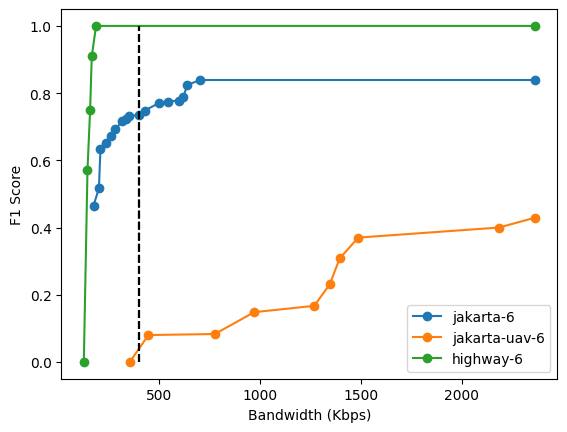

In [6]:
# plot_profile(*(i for i in range(7,9)))
plot_profile(6)

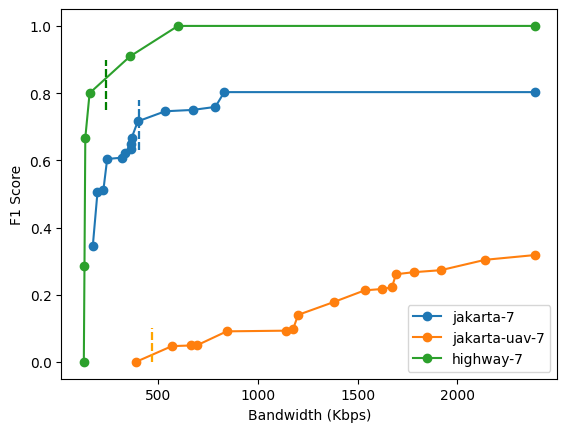

In [56]:
plot_profile(7)

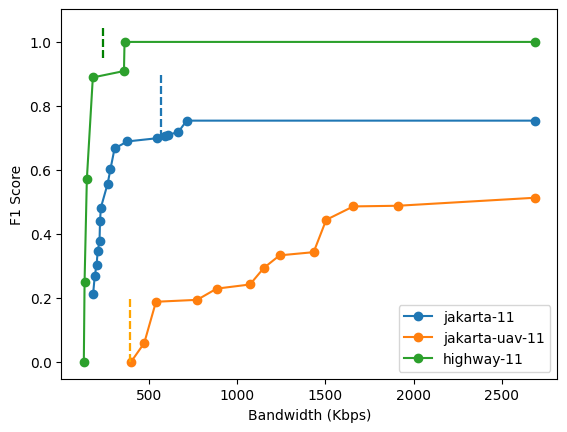

In [38]:
plot_profile(10)

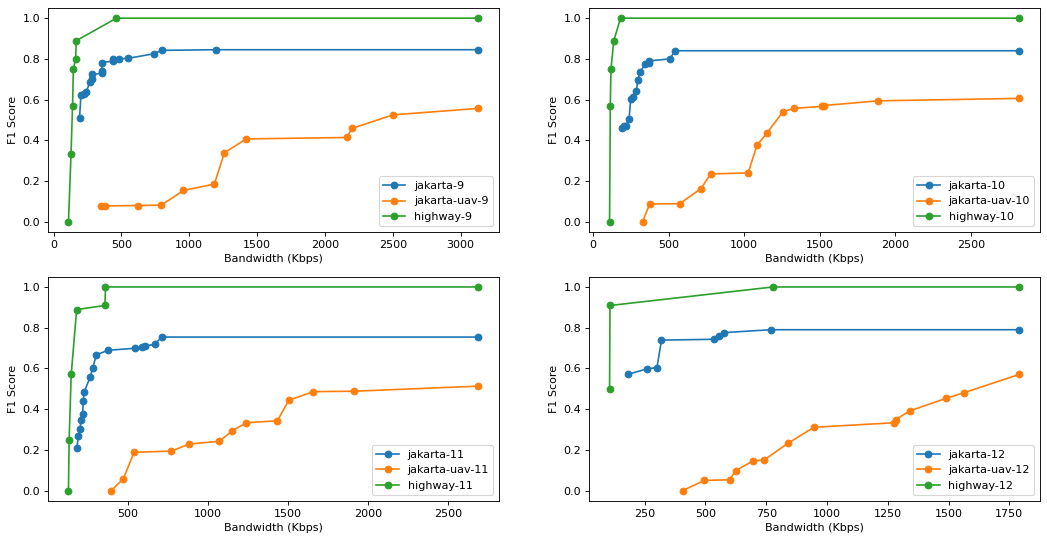

In [9]:
plot_profile(9,10,11,12)

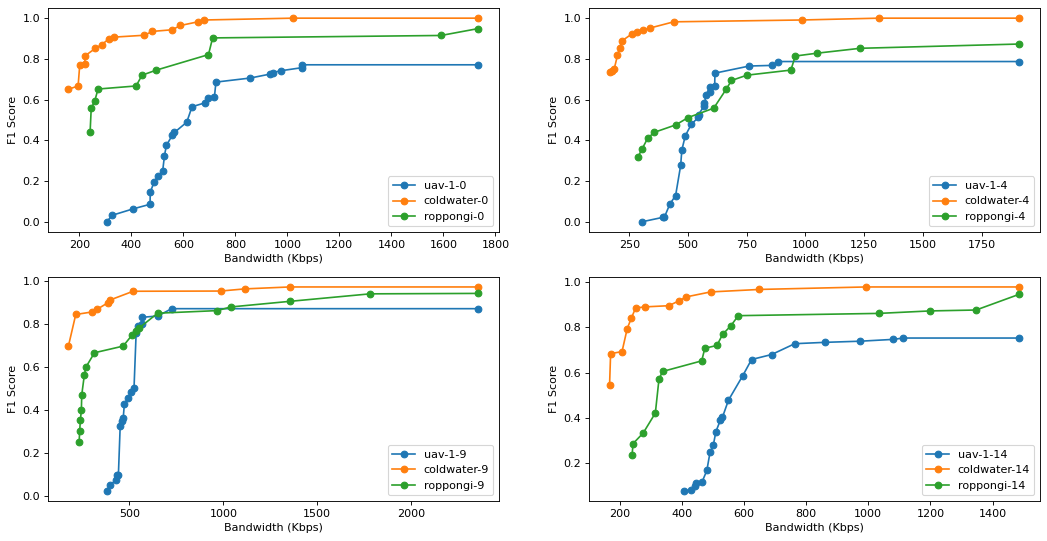

In [59]:
plot_profile(0,4,9,14)

/home/cc/miniconda3/envs/dds/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


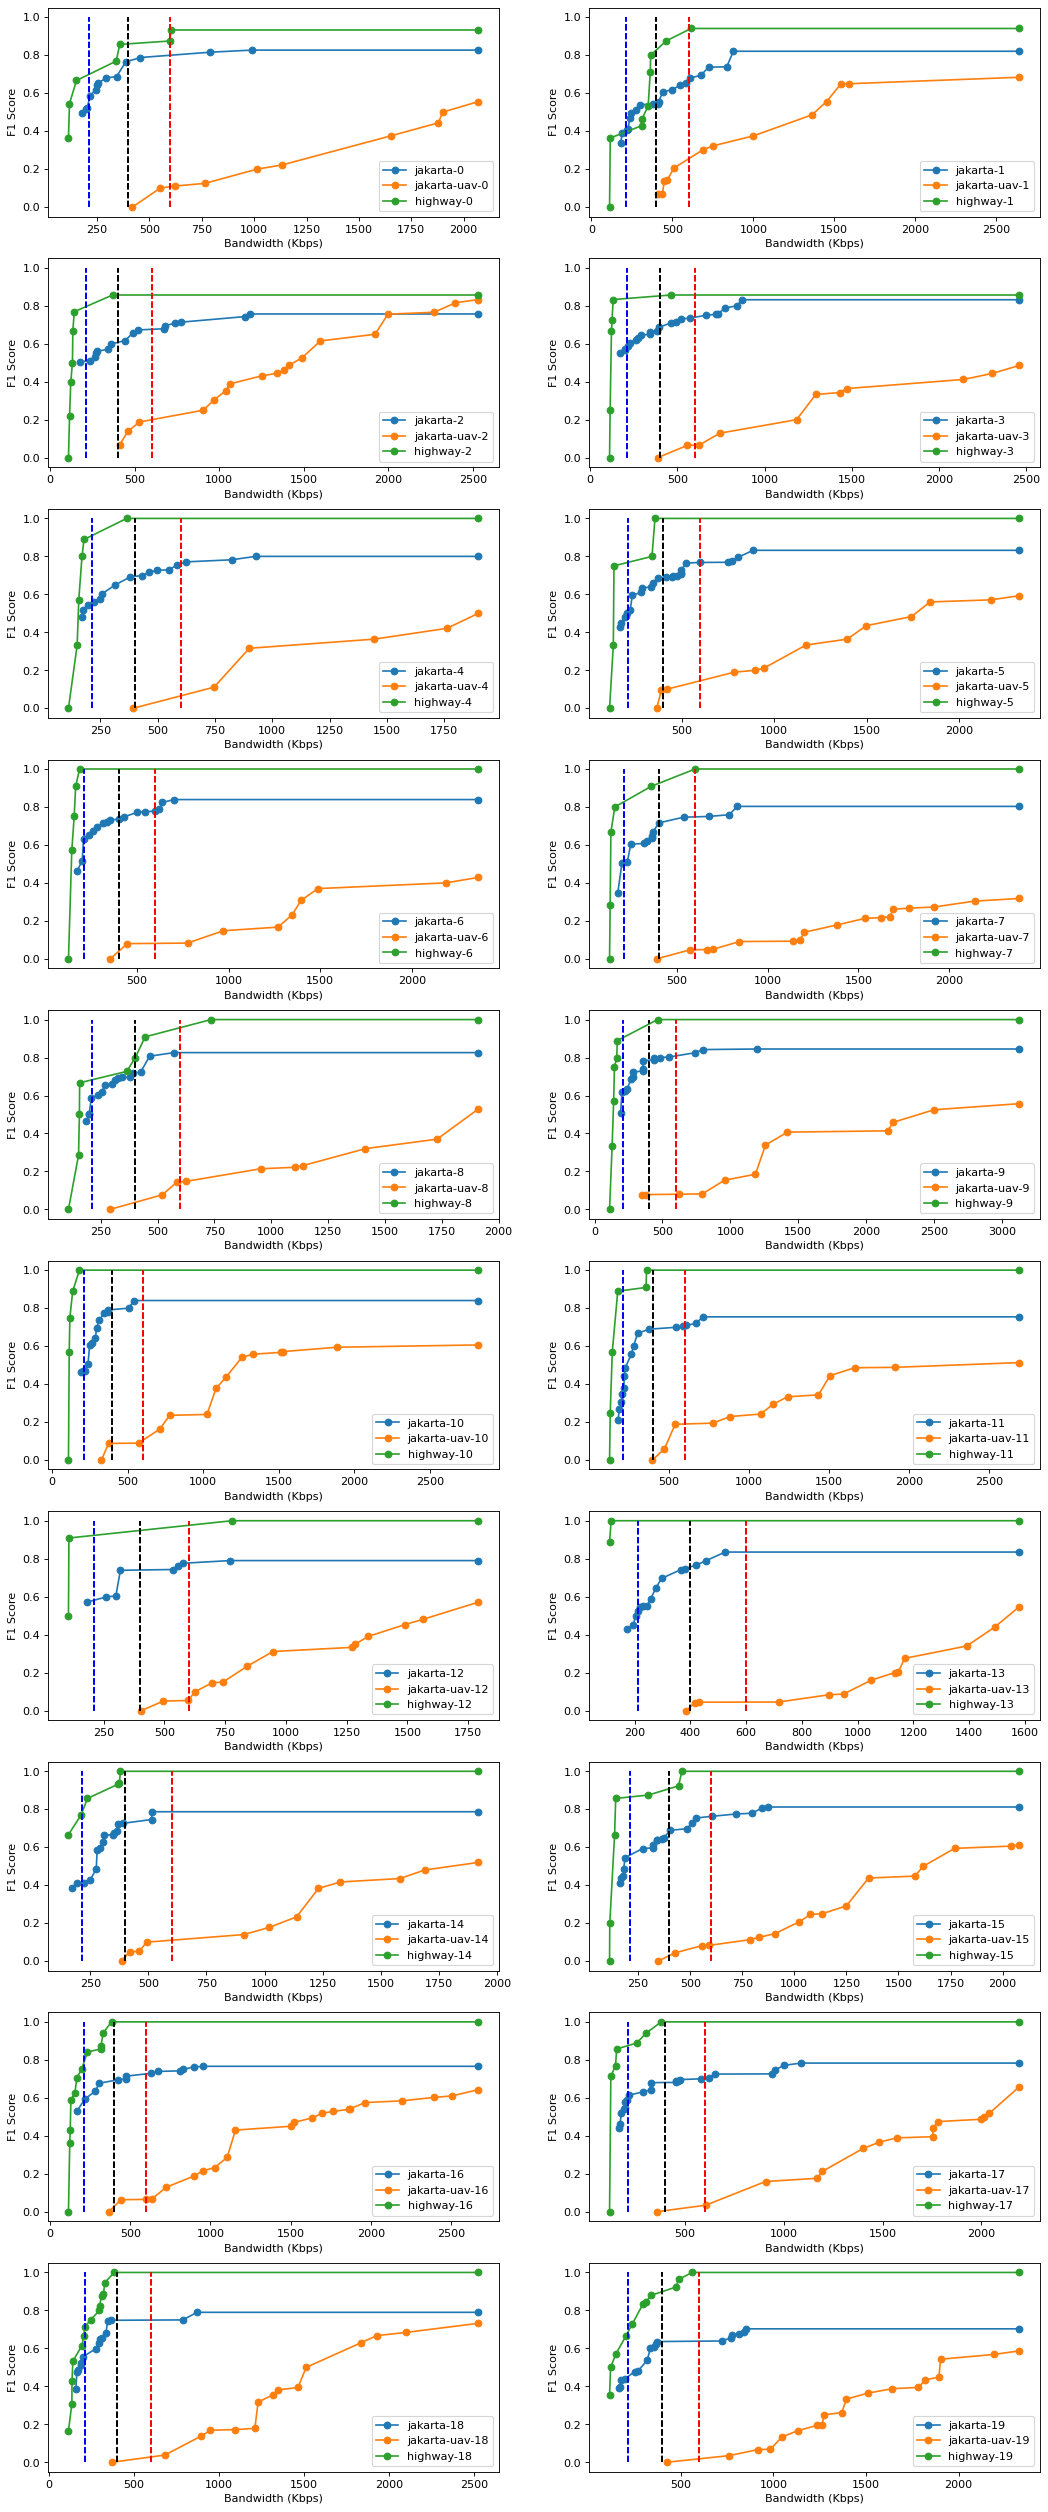

In [5]:
plot_profile(*(i for i in range(20)))

## Playground

In [58]:

# profile_rene_adaptive = pd.read_csv("./profile-rene/profile-separated/profile-5.csv")
# profile_rene_adaptive
# profile_rene_adaptive_aws = pd.read_csv("./profile-rene-aws/profile-separated/profile-5.csv")
# F1_Bandwidth_limit_plot_compare(profile_rene_adaptive, "Rene-5", profile_rene_adaptive_aws, "Rene-aws-5")





# # Line Plotting
# plt.figure(figsize=(10,10))
# fig, ax = plt.subplots(2,2)
# fig.tight_layout(pad=3)
# fig.subplots_adjust(hspace=0.6, wspace=0.3)

# # plt.plot(bandwidth, reneOfflineE2E/2 + uav1OfflineE2E/2, 'o-')
# # plt.plot(bandwidth, reneFairE2E/2 + uav1FairE2E/2, 'o-')

# # plt.plot(bandwidth, reneOfflineTransmission/2 + uav1OfflineTransmission/2, 'o-', label='offline')
# # plt.plot(bandwidth, reneFairTransmission/2 + uav1FairTransmission/2, 'o-', label='fair')
# # plt.legend()

# ax[0,0].plot(test1)
# # ax[0][0].xlabel("Bandwidth (kbit/s)")
# # ax[0][0].ylabel("Total F1-score")
# # ax[0][0].legend()

# ax[0,1].plot(test2)
# # ax[0][1].xlabel("Bandwidth (kbit/s)")
# # ax[0][1].ylabel("Total F1-score")
# # ax[0][1].legend()

# ax[1,0].plot(test3)


# ax[1,1].plot(test4)


# for a in ax.flat:
#     a.set(xlabel='bandwidth (kbit/s)', ylabel='latency (s)')

# plt.figlegend(['offline-profile', 'fair-allocation'], loc='upper right', fontsize='xx-small')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for a in ax.flat:
#     a.label_outer()

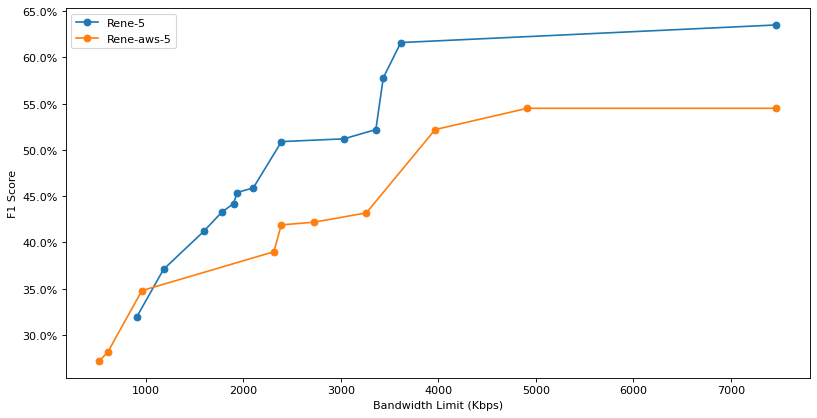

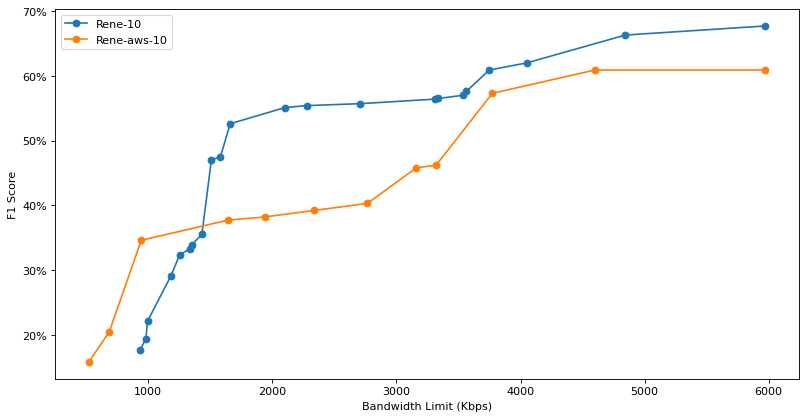

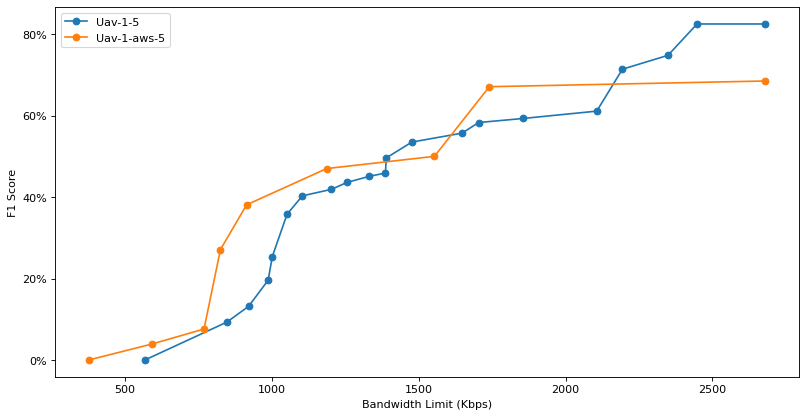

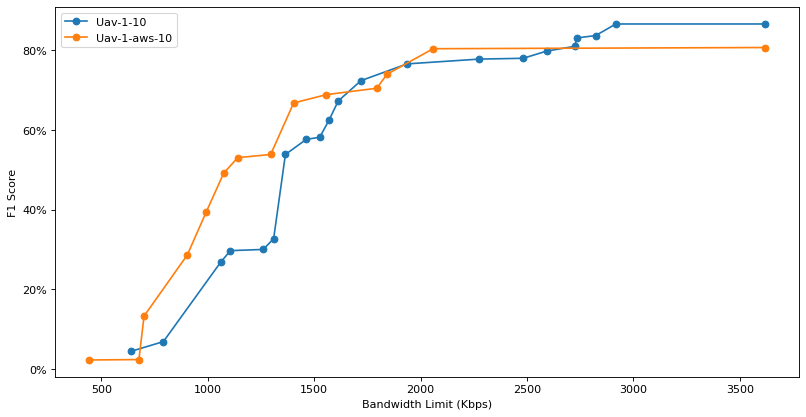

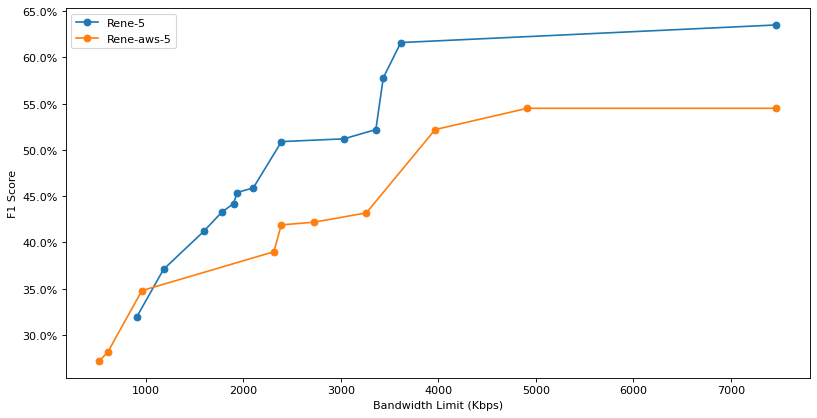

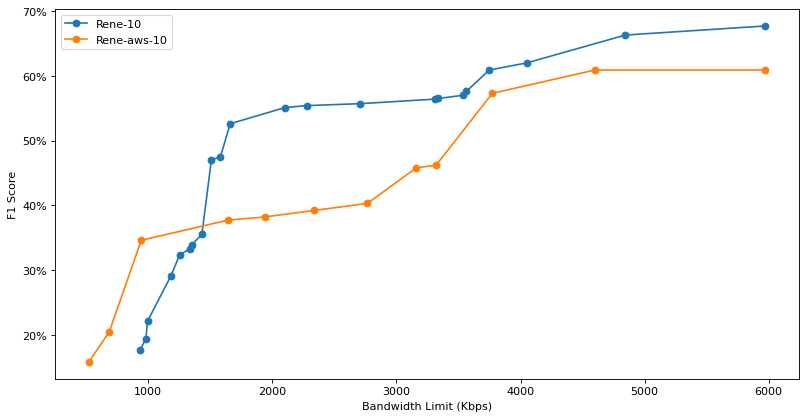

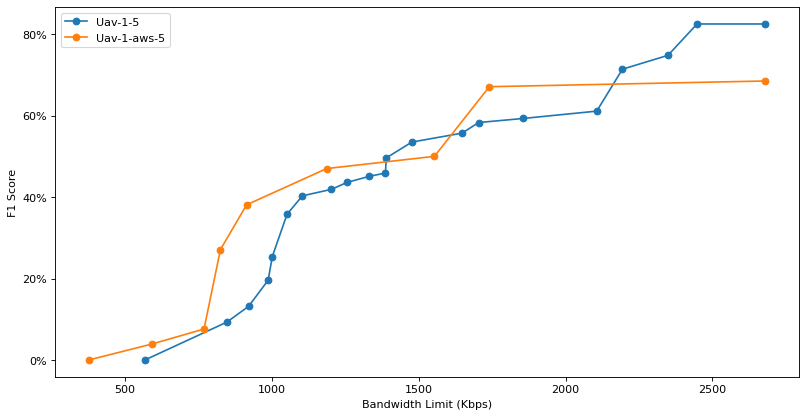

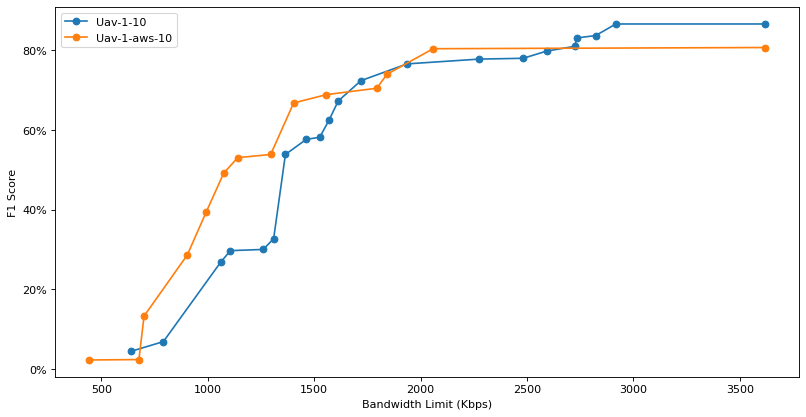

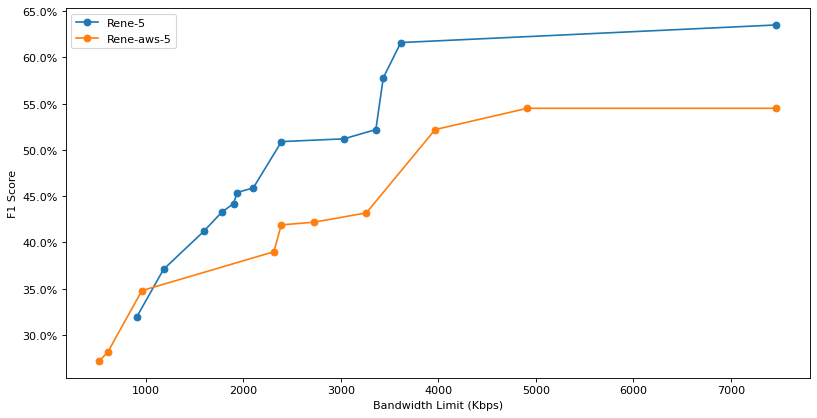

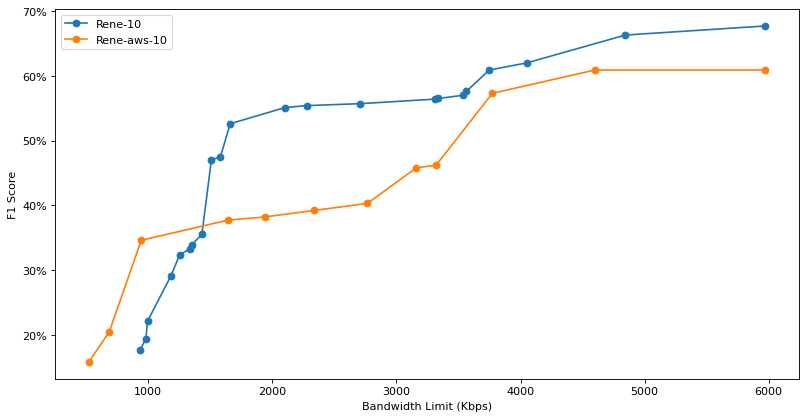

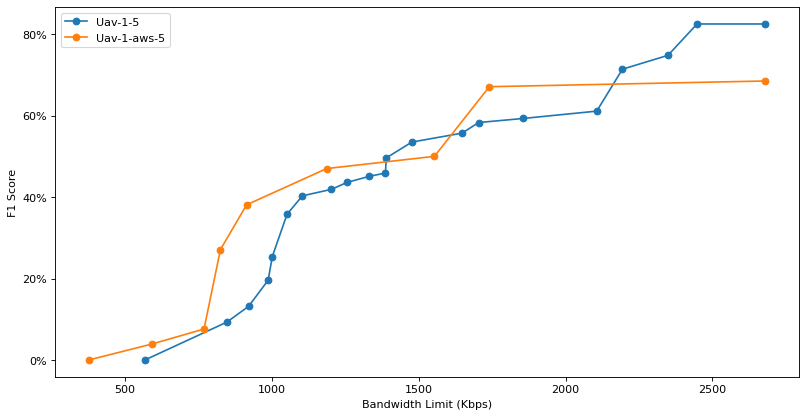

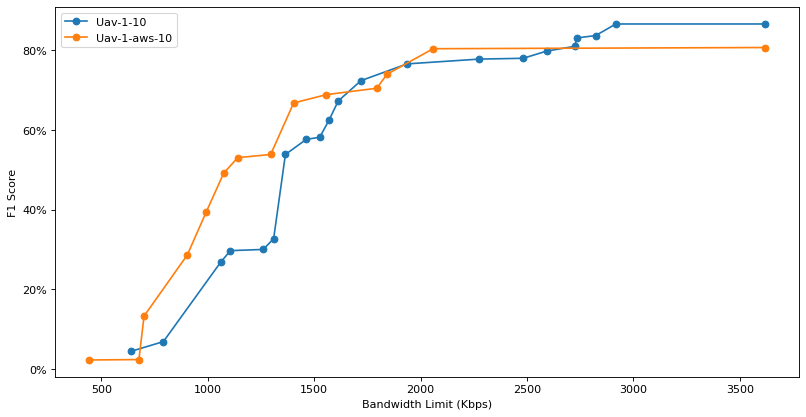

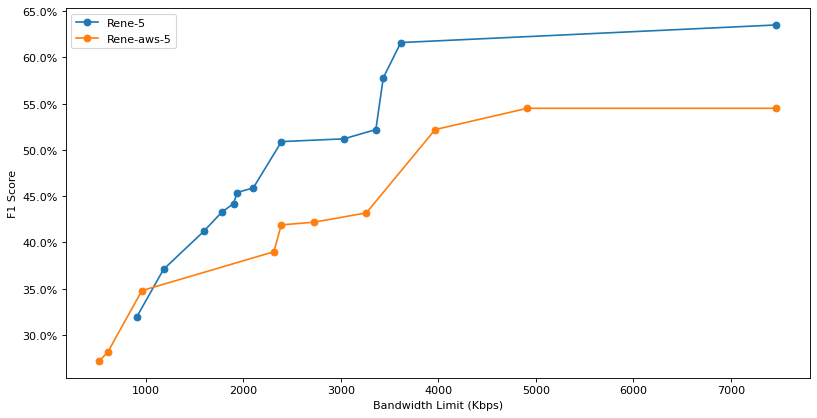

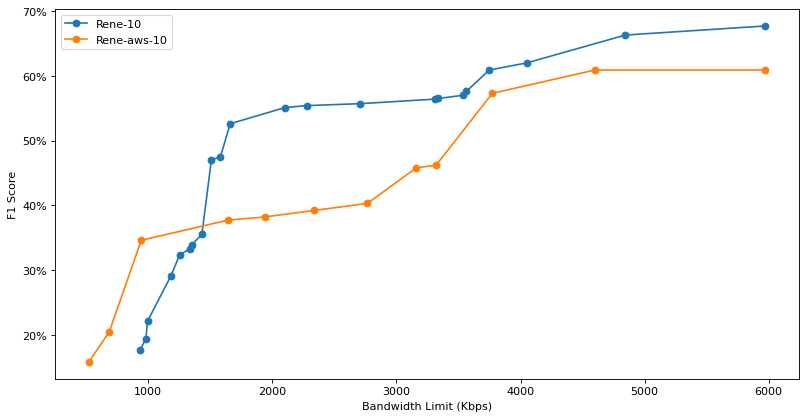

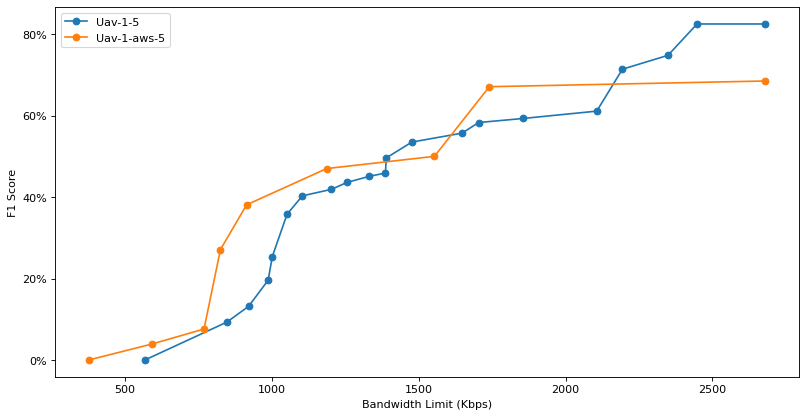

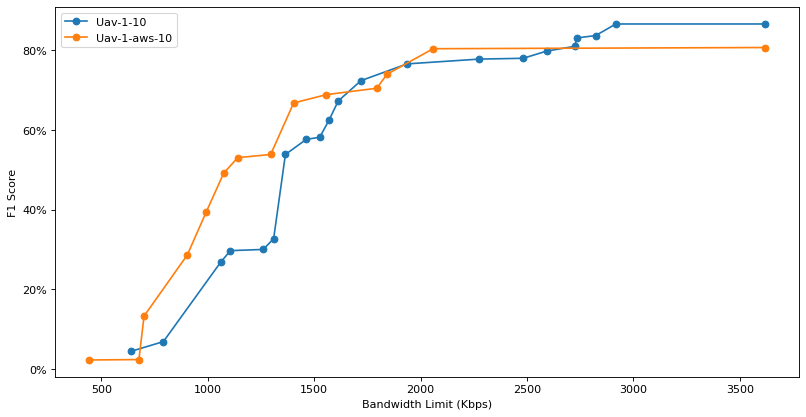

<Figure size 1000x1000 with 0 Axes>

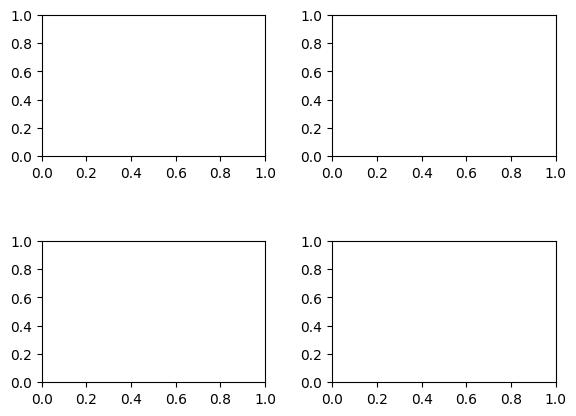

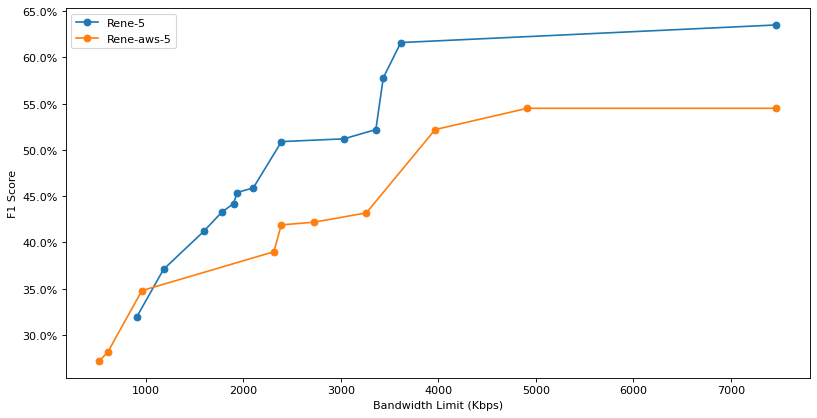

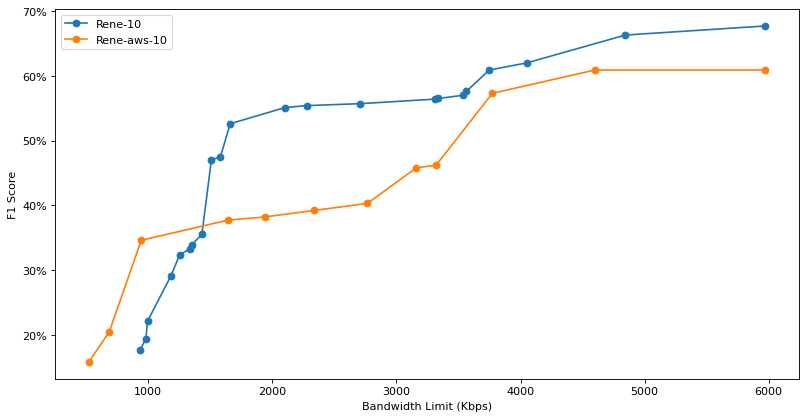

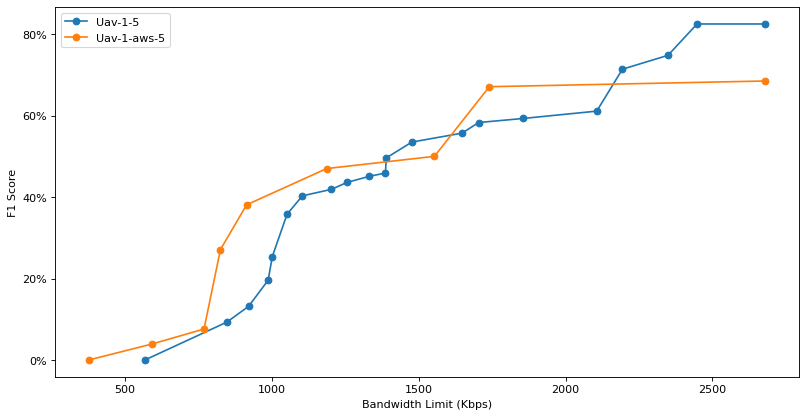

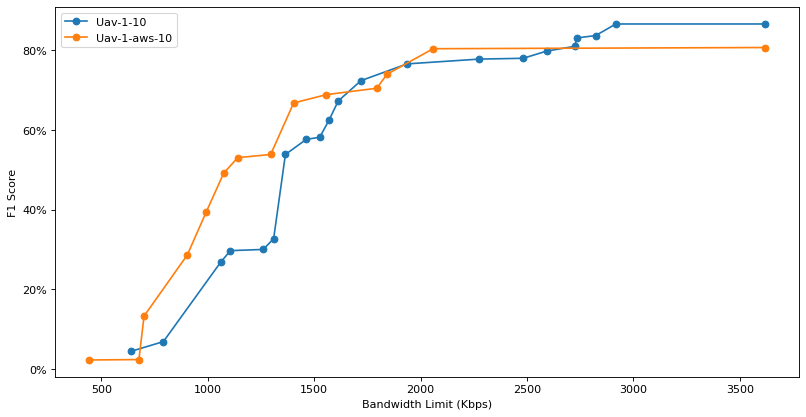

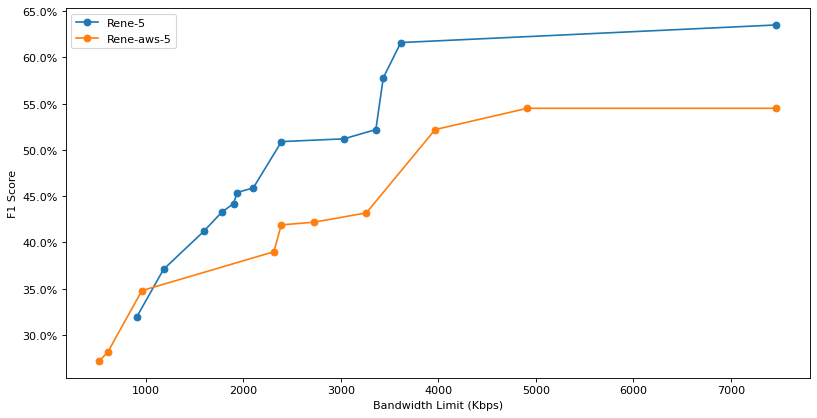

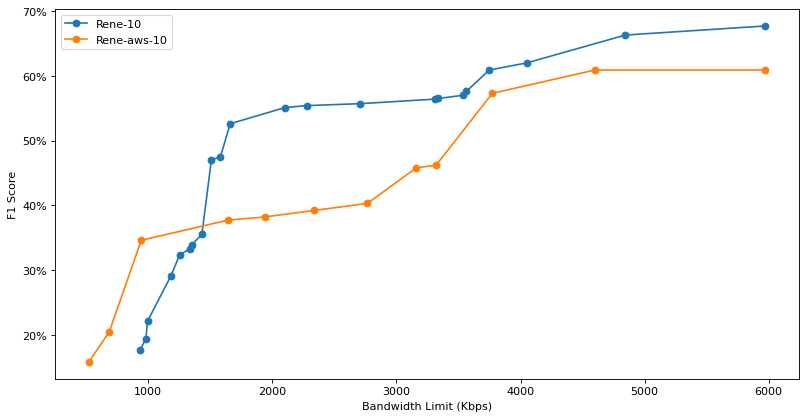

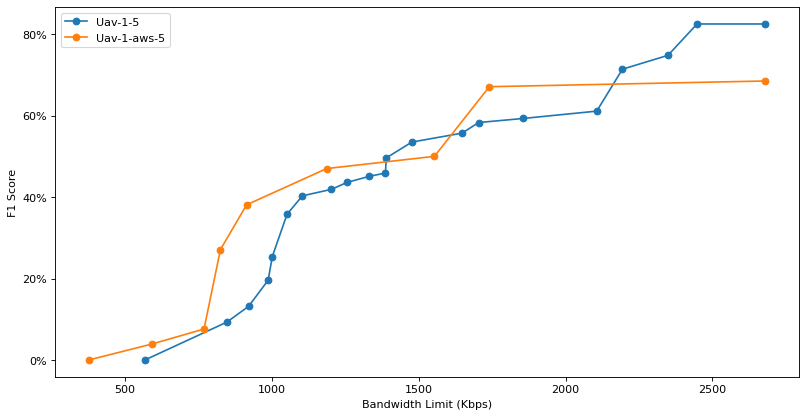

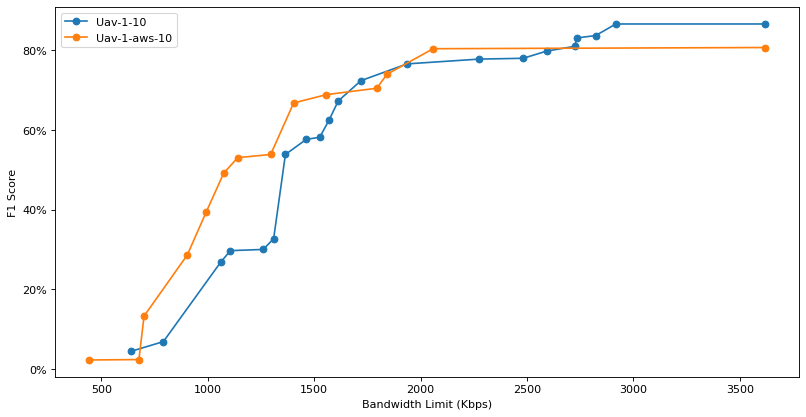

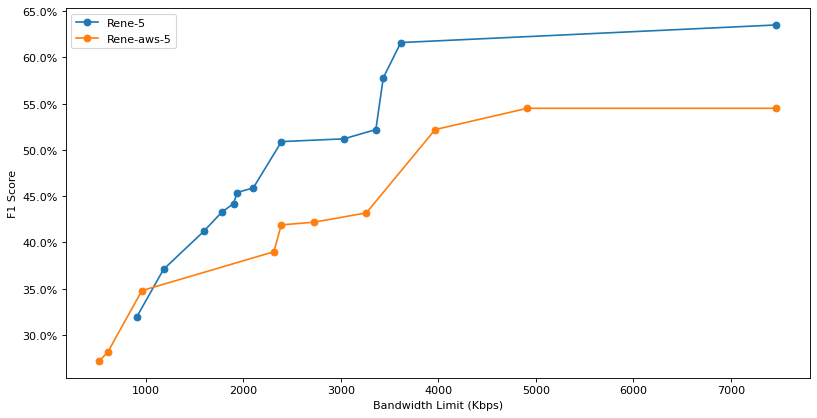

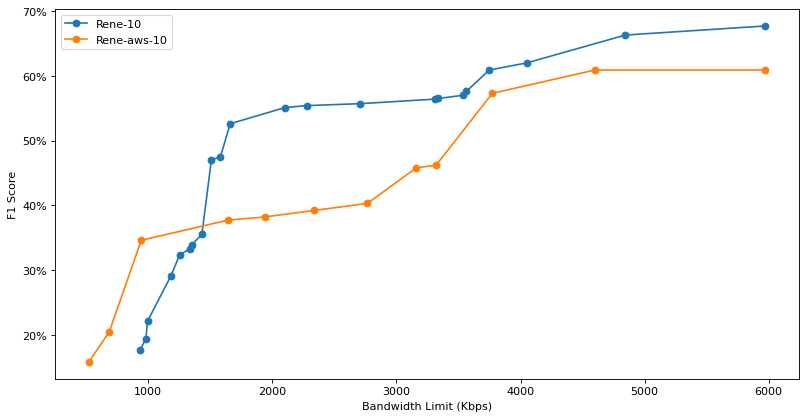

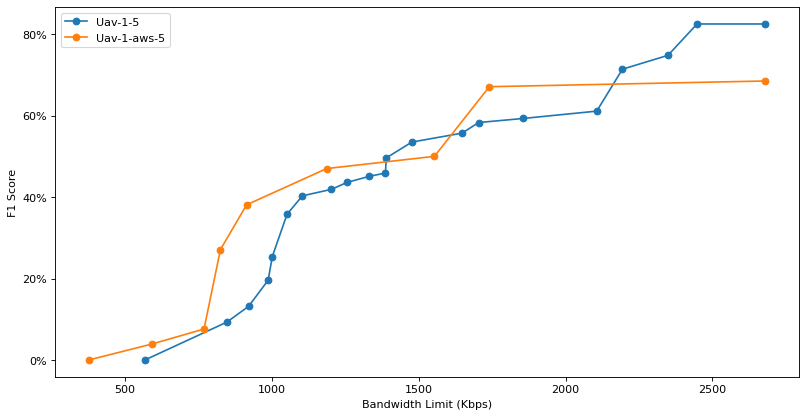

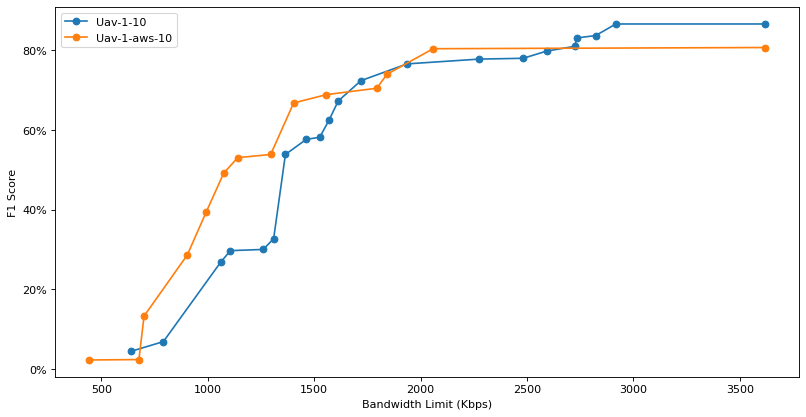

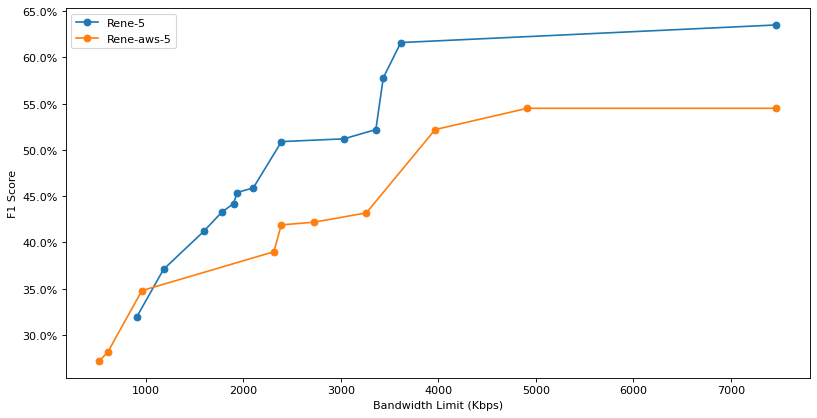

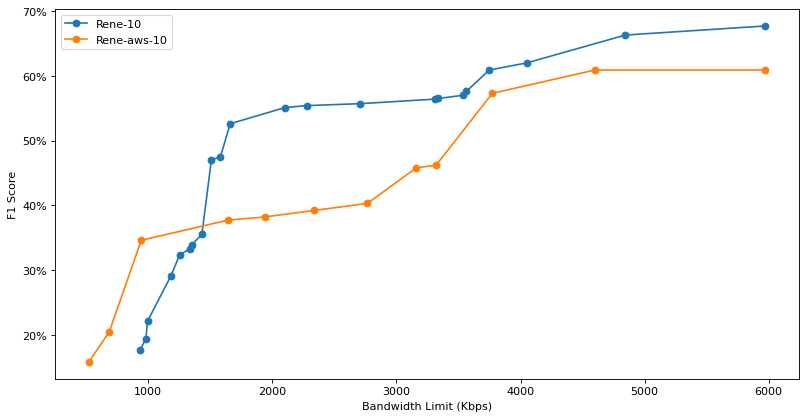

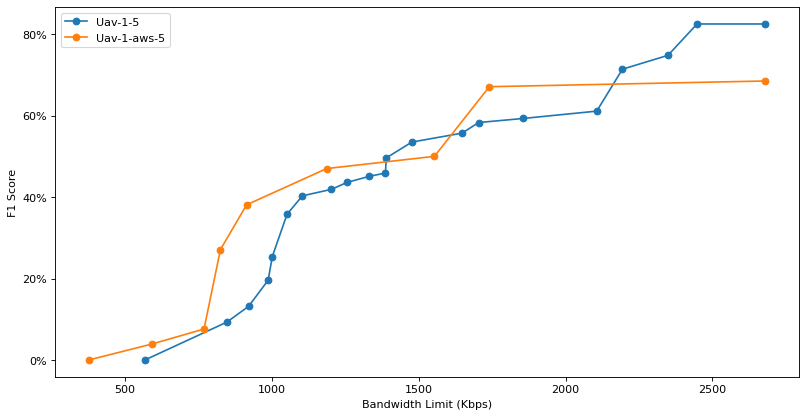

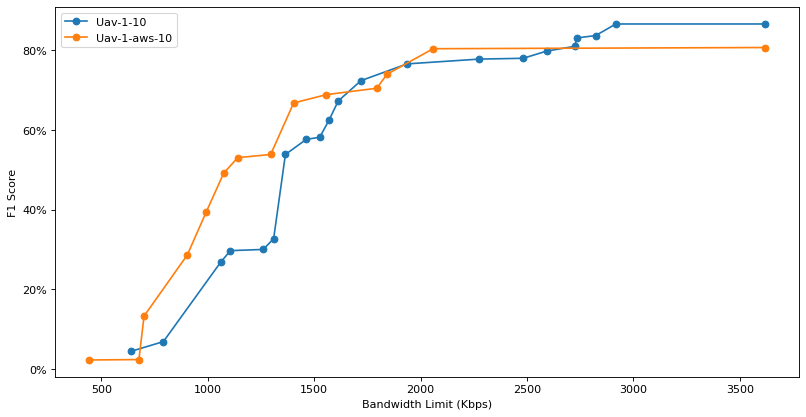

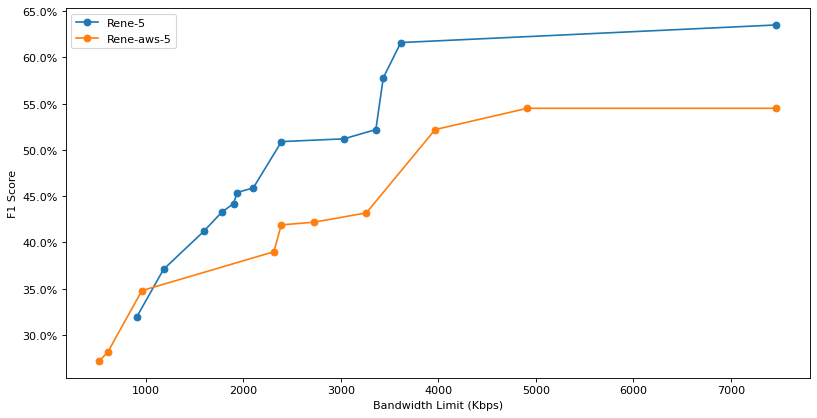

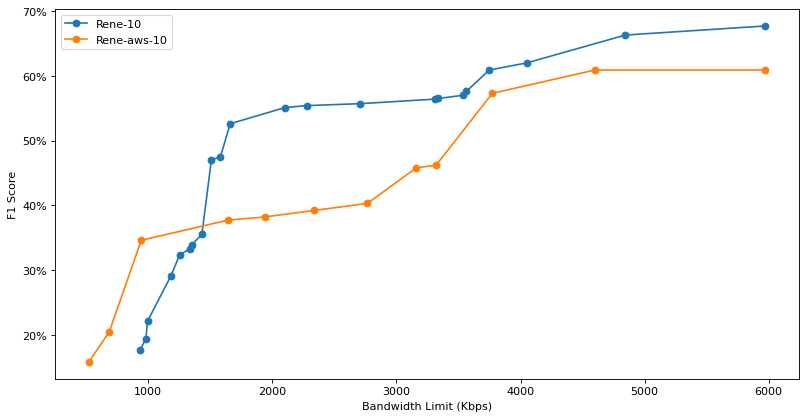

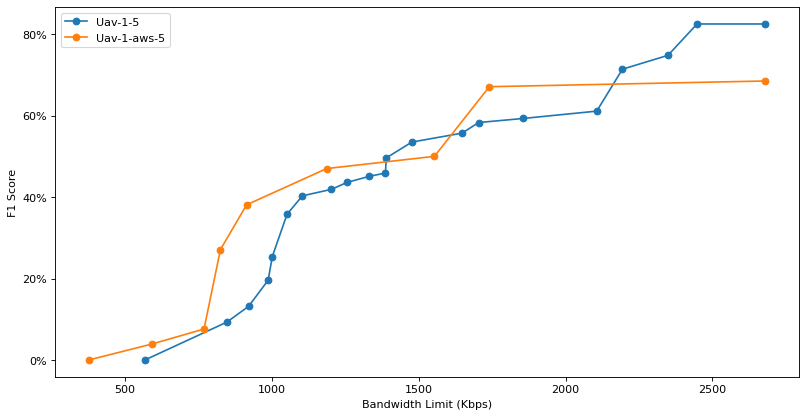

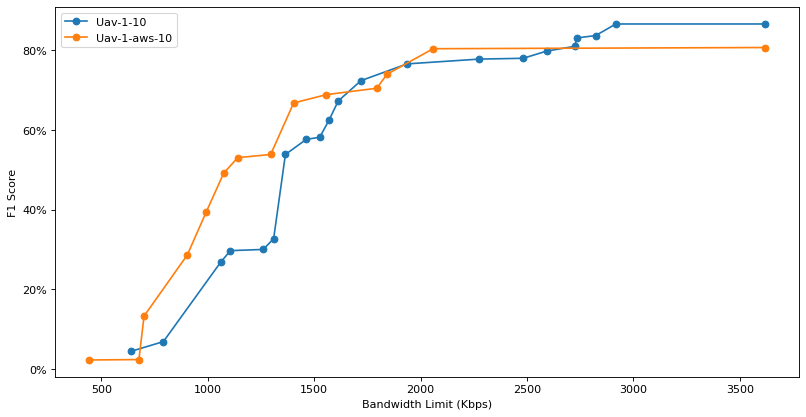

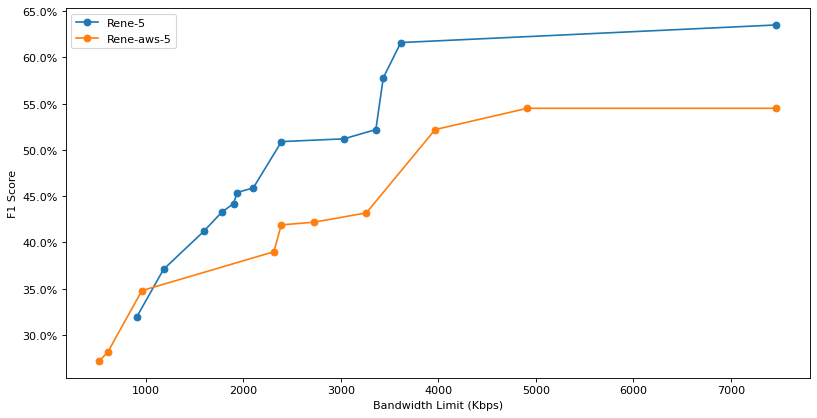

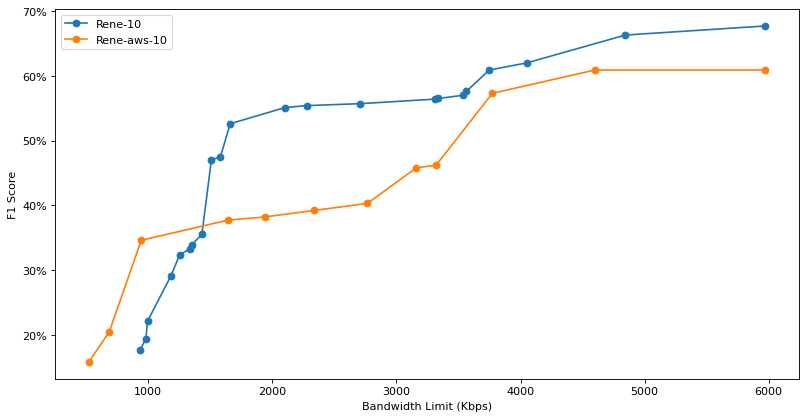

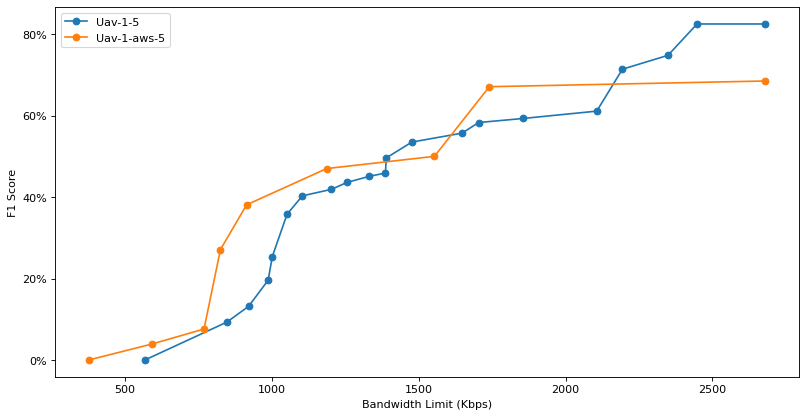

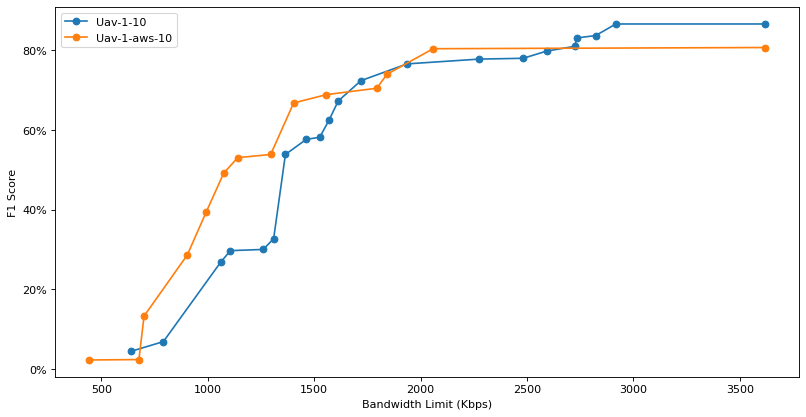

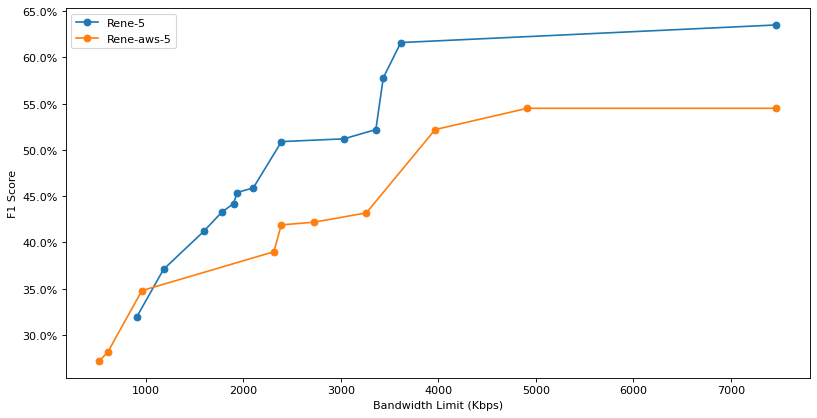

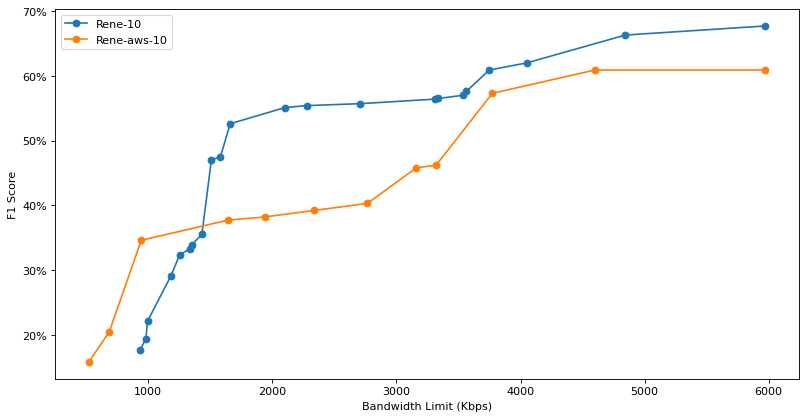

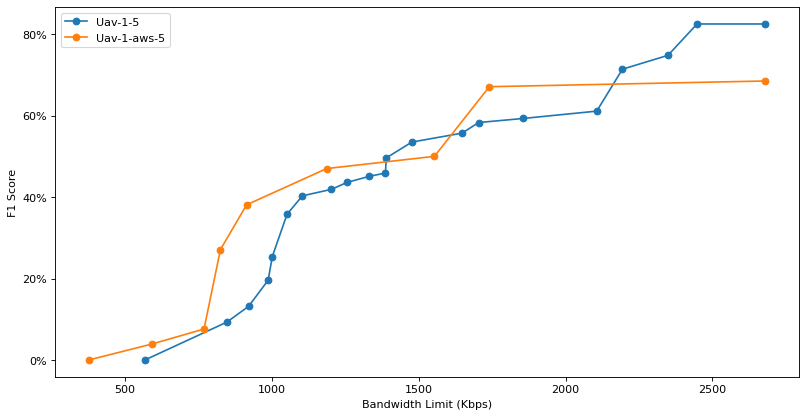

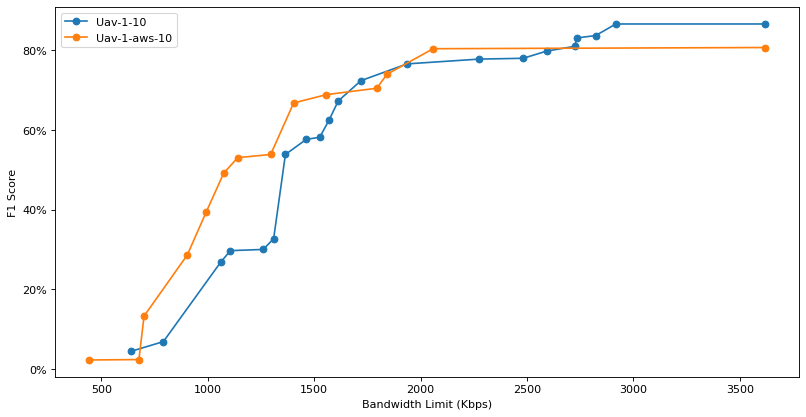

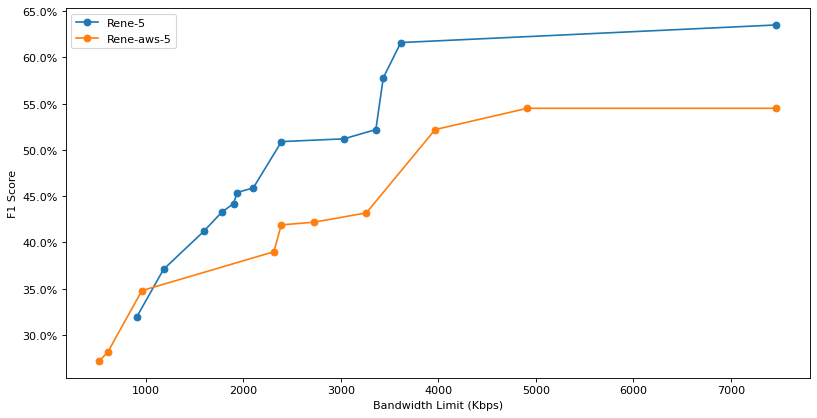

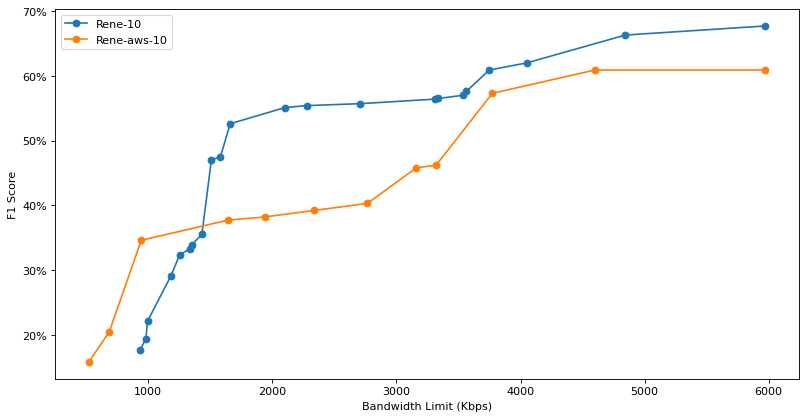

In [59]:
profile_rene_adaptive = pd.read_csv("./profile-rene/profile-separated/profile-10.csv")
profile_rene_adaptive
profile_rene_adaptive_aws = pd.read_csv("./profile-rene-aws/profile-separated/profile-10.csv")
F1_Bandwidth_limit_plot_compare(profile_rene_adaptive, "Rene-10", profile_rene_adaptive_aws, "Rene-aws-10")





In [55]:
profile_rene_adaptive = pd.read_csv("./profile-uav-1/profile-separated/profile-5.csv")
profile_rene_adaptive
profile_rene_adaptive_aws = pd.read_csv("./profile-uav-1-aws/profile-separated/profile-5.csv")
F1_Bandwidth_limit_plot_compare(profile_rene_adaptive, "Uav-1-5", profile_rene_adaptive_aws, "Uav-1-aws-5")




In [56]:
profile_rene_adaptive = pd.read_csv("./profile-uav-1/profile-separated/profile-10.csv")
profile_rene_adaptive
profile_rene_adaptive_aws = pd.read_csv("./profile-uav-1-aws/profile-separated/profile-10.csv")
F1_Bandwidth_limit_plot_compare(profile_rene_adaptive, "Uav-1-10", profile_rene_adaptive_aws, "Uav-1-aws-10")

/home/cc/miniconda3/envs/dds/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


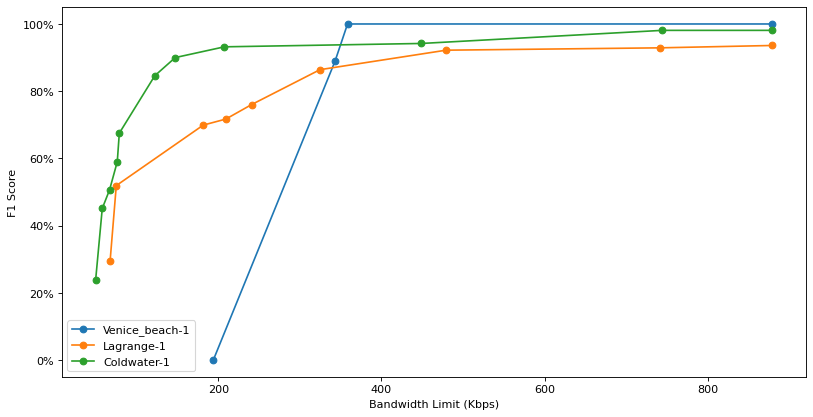

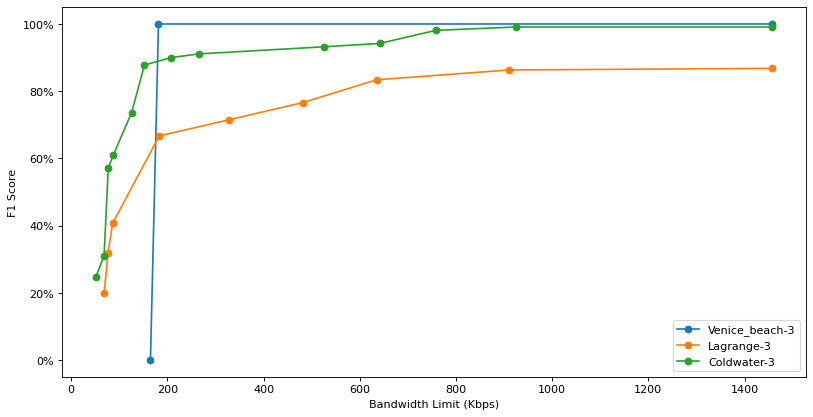

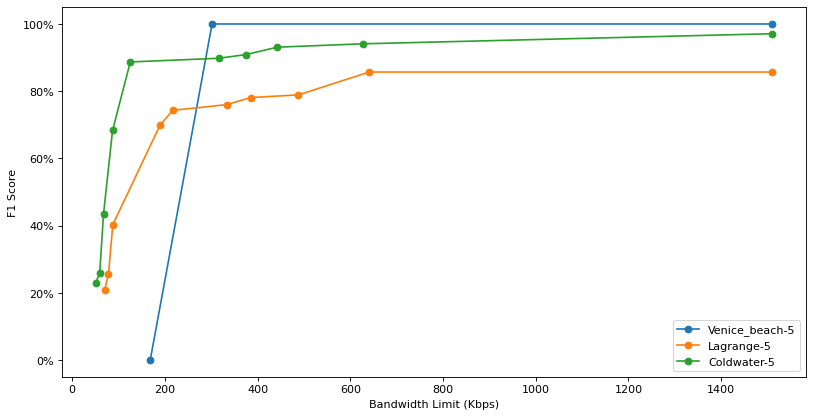

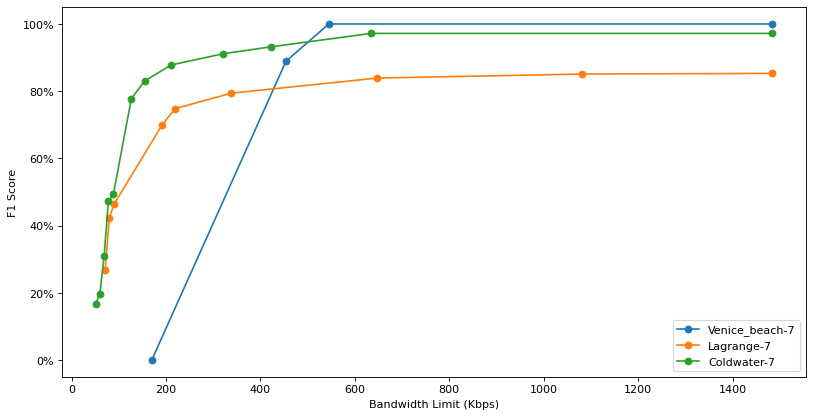

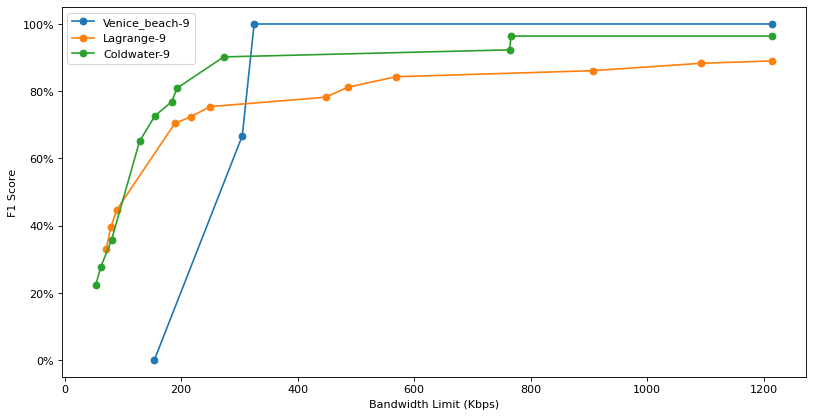

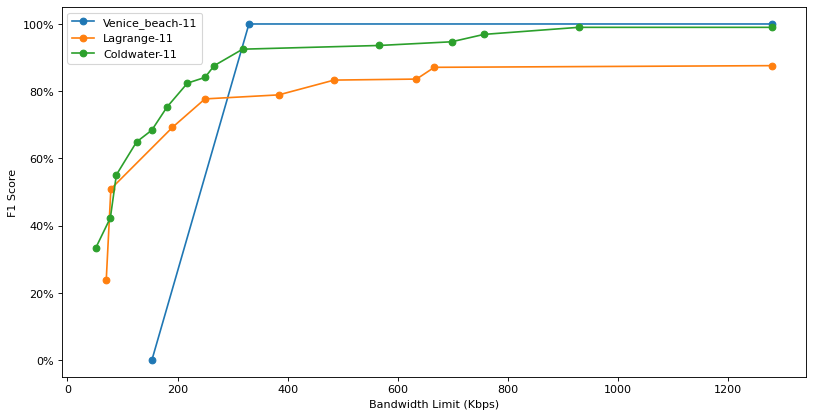

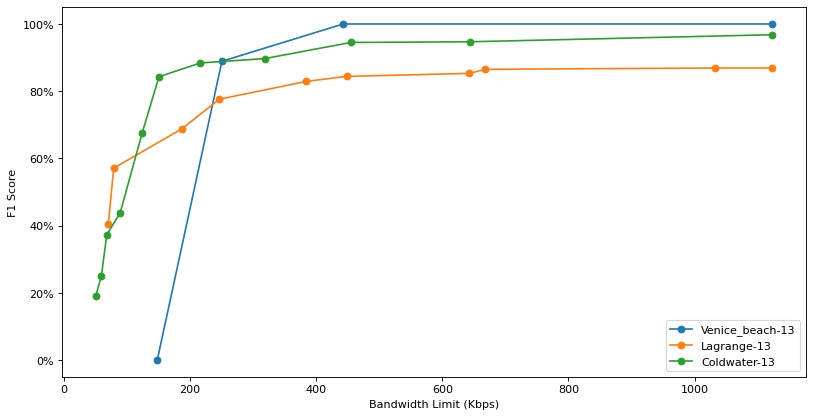

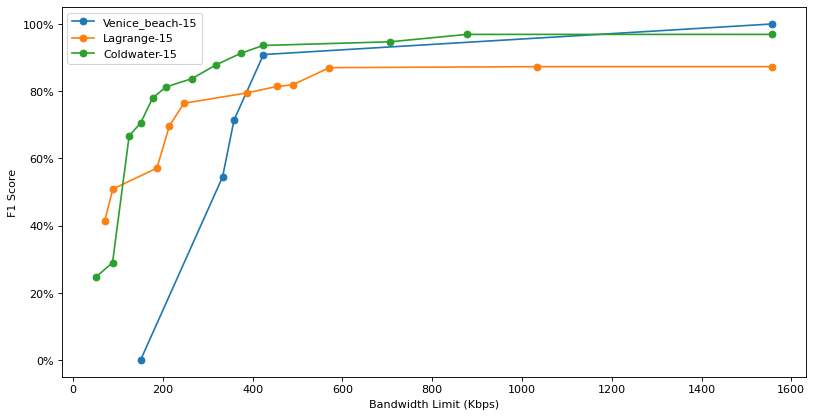

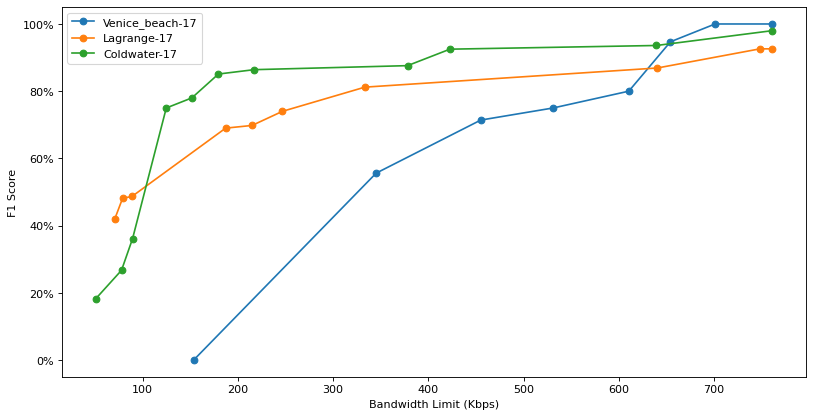

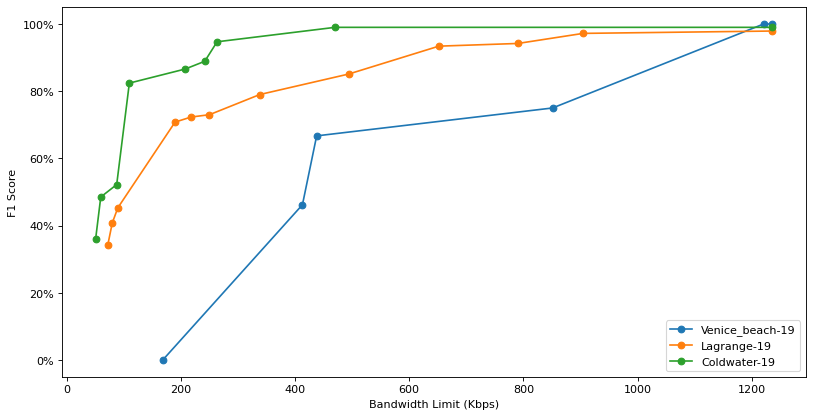

In [4]:
for i in range(1,20,2):
    profile_venice_beach = pd.read_csv(f"~/VAP-Concierge/src/app/dds-adaptive/data-set/venice-beach/profile/profile-{i}.csv")
    profile_lagrange = pd.read_csv(f"~/VAP-Concierge/src/app/awstream-adaptive/data-set/lagrange/profile/profile-{i}.csv")
    profile_coldwater = pd.read_csv(f"~/VAP-Concierge/src/app/awstream-adaptive/data-set/coldwater/profile/profile-{i}.csv")
    F1_Bandwidth_limit_plot_compare(profile_venice_beach, f"Venice_beach-{i}", profile_lagrange, f"Lagrange-{i}", profile_coldwater, f"Coldwater-{i}")

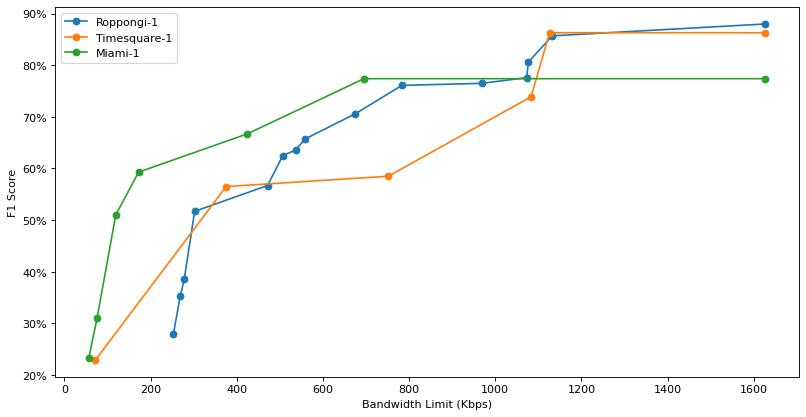

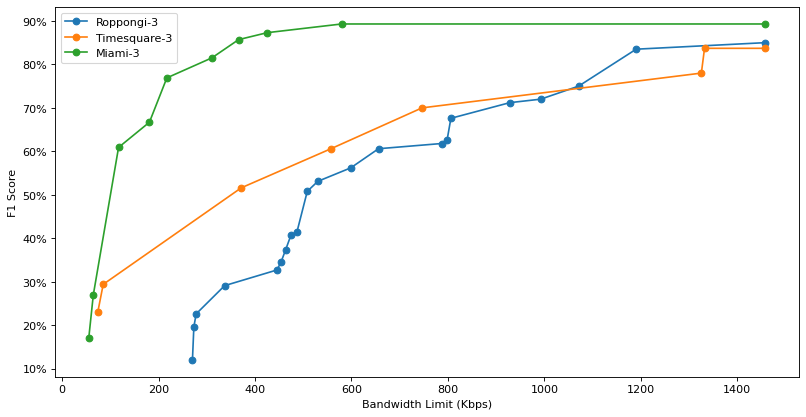

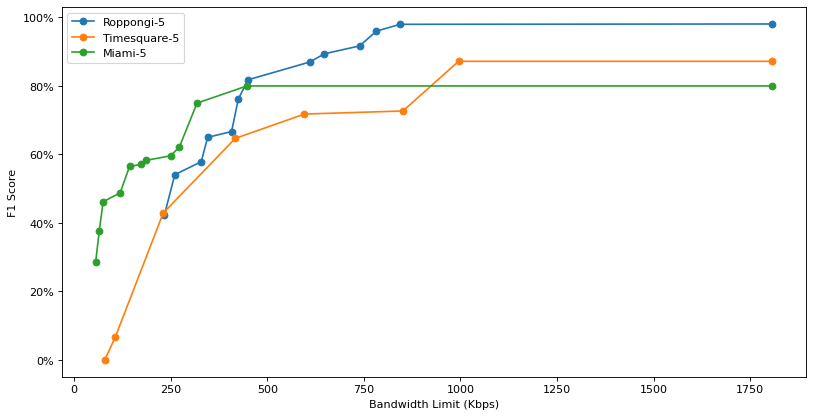

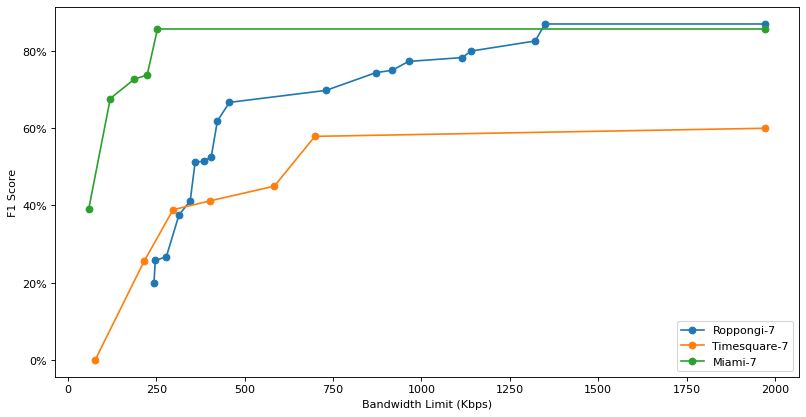

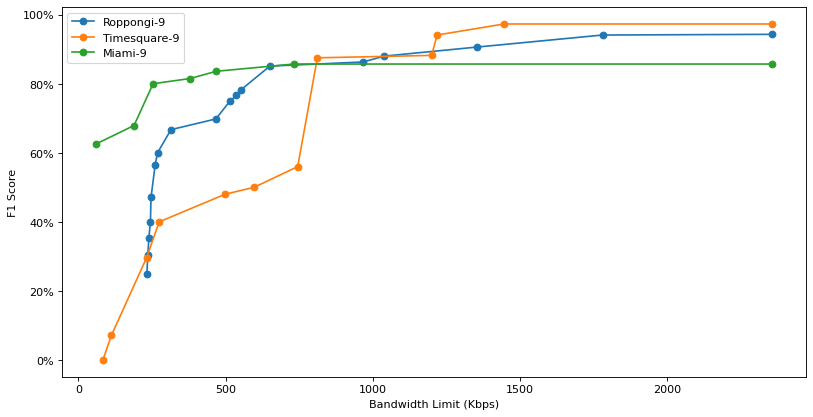

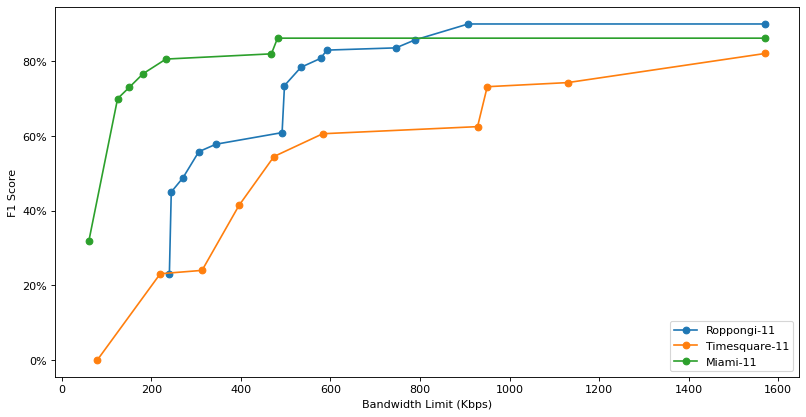

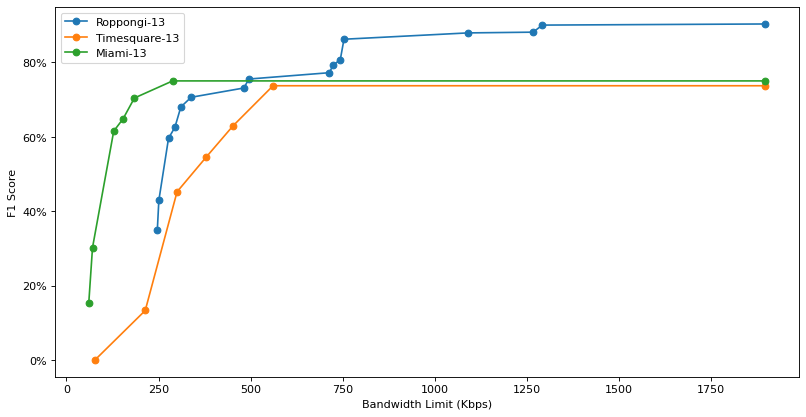

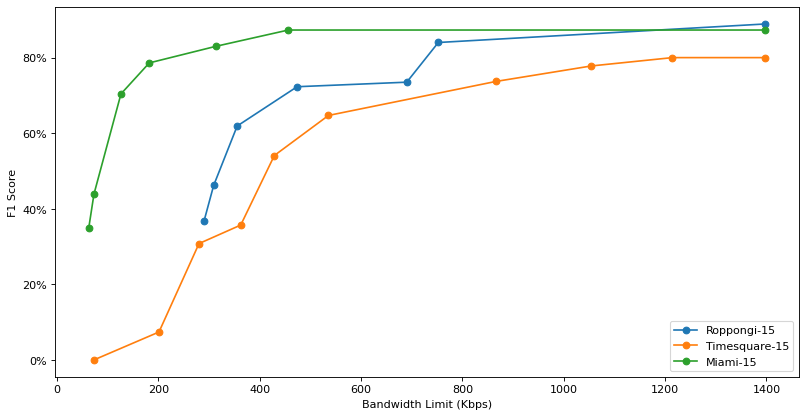

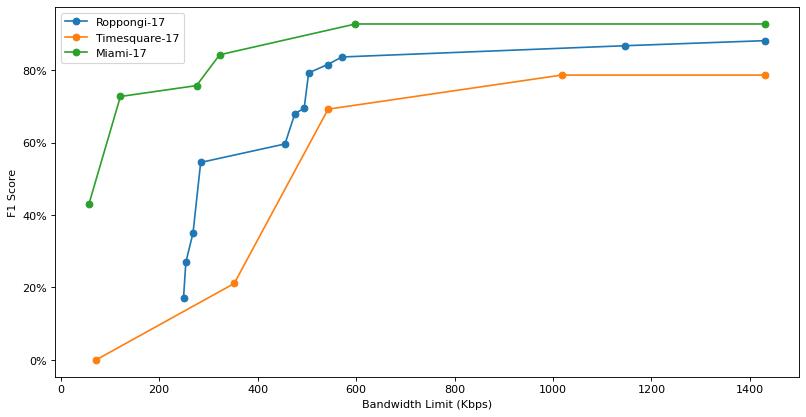

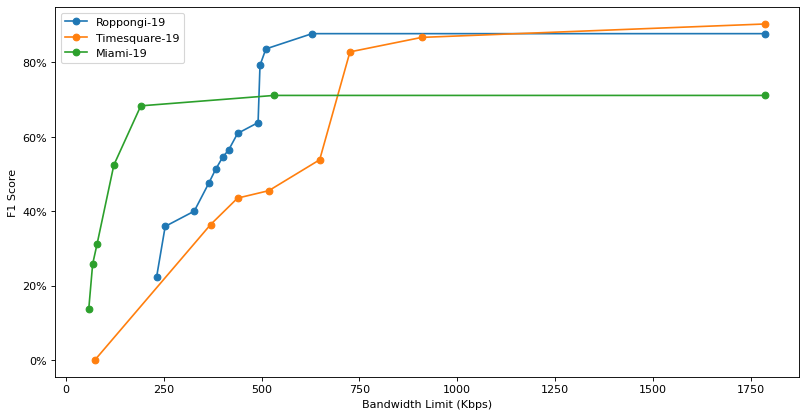

In [7]:
for i in range(1,20,2):
    profile_venice_beach = pd.read_csv(f"~/VAP-Concierge/src/app/dds-adaptive/data-set/roppongi/profile/profile-{i}.csv")
    profile_lagrange = pd.read_csv(f"~/VAP-Concierge/src/app/awstream-adaptive/data-set/timesquare/profile/profile-{i}.csv")
    profile_coldwater = pd.read_csv(f"~/VAP-Concierge/src/app/awstream-adaptive/data-set/miami/profile/profile-{i}.csv")
    F1_Bandwidth_limit_plot_compare(profile_venice_beach, f"Roppongi-{i}", profile_lagrange, f"Timesquare-{i}", profile_coldwater, f"Miami-{i}")

In [41]:
len(profile_rene.index)

45

In [42]:
len(profile_rene_adaptive.index)
# profile_rene_adaptive

44

## Deep dive into every decision

In [17]:
Date = "07-29"
result_archive_path = "result_archive"

NUM_APP = 3
app_names = ["", "dds-adaptive", "dds-adaptive", "dds-adaptive"]
app_names_abbr = ["" if app == "" else app[0] for app in app_names]
video_names = ["", "jakarta", "jakarta-uav", "highway"]
video_names_abbr = ["" if video == "" else video[0] for video in video_names]

baseline = False

postfix = None

MIN_BW = 80
MAX_BW = 1200
PROFILE_DELTA = 80

nframes = 125
segment_size = 5 # ⚠️ for now, treating segment_size = batch_size!!!

In [18]:
# Result archive name: Date-#app-app1...-appn-video1...-videon-minbw-maxbw-profiledelta

experiment_name = f"{Date}"
experiment_name += f"-{NUM_APP}"
for i in range(1, NUM_APP + 1):
    experiment_name += f"-{app_names_abbr[i]}"
for i in range(1, NUM_APP + 1):
    experiment_name += f"-{video_names_abbr[i]}"
experiment_name += f"-{MIN_BW}-{MAX_BW}-{PROFILE_DELTA}-5"
if postfix:
    experiment_name += f"-{postfix}"
if baseline:
    experiment_name += "-baseline"

result_path = f"~/VAP-Concierge/src/{result_archive_path}/{experiment_name}/app"

In [20]:
log = [""]
log_baseline = [""]
reallocation_segment_mode = True


if reallocation_segment_mode:
    for app_idx in range(1, NUM_APP + 1):
        log.append(pd.read_csv(f"~/VAP-Concierge/src/{result_archive_path}/{experiment_name}/app/app{app_idx}/workspace/logs/log_realloc"))
        #log_baseline.append(pd.read_csv(f"{result_archive_path}/{baseline_experiment_name}/app/app{app_idx}/workspace/logs/log_realloc"))
else:
    for app_idx in range(1, NUM_APP + 1):
        log.append(pd.read_csv(f"{result_archive_path}/{experiment_name}/app/app{app_idx}/workspace/logs/log"))
        #log_baseline.append(pd.read_csv(f"{result_archive_path}/{baseline_experiment_name}/app/app{app_idx}/workspace/logs/log"))

log[0] = log[1].copy()
# log_baseline[0] = log_baseline[1].copy()
for app_idx in range(2, NUM_APP + 1):
    log[0]['f1'] += log[app_idx]['f1']
#     log[app_idx]['bw'] = 400
    # log_baseline[0]['f1'] += log_baseline[app_idx]['f1']
# log[1]['bw'] = 400

In [25]:
log[1], log[2], log[3]

(    fid     bw  low_res  high_res  low_qp  high_qp  just_realloc     f1
 0     0  400.0      0.3       0.5      34       28         False  0.765
 1     5  400.0      0.3       0.5      34       28          True  0.570
 2    15  400.0      0.3       0.5      32       28          True  0.690
 3    25  407.0      0.3       0.6      34       28          True  0.712
 4    35  407.0      0.4       0.4      34       28          True  0.717
 5    45  487.0      0.3       0.7      32       28          True  0.800
 6    50  567.0      0.3       1.0      32       28          True  0.840
 7    55  567.0      0.4       0.4      30       28          True  0.699
 8    60  567.0      0.4       0.4      30       26          True  0.795
 9    70  487.0      0.3       0.4      32       24          True  0.712
 10   80  428.0      0.4       0.4      32       28          True  0.695
 11   80  428.0      0.4       0.4      32       28          True    NaN,
     fid     bw  low_res  high_res  low_qp  high_q

In [48]:
# profileNum only accepts 1 or even number of profile at this moment(?)
def plot_profile_debug(idx, *profileNum):
    # creating the figure template
    numOfProfiles = 1
#     row = 0
#     col = 0
#     if(numOfProfiles == 1):
#         row = 1
#         col = 1
#     else:
#         row = numOfProfiles//2
#         col = 2
    
    
    # calculate all of the sensitivities
    profiles = []
    labels = []
#     dataset = ["highway", "jakarta", "roppongi", "coldwater", "jakarta-uav", "timesquare", "hochiminh", "lagrange", "uav-1", "miami"]
#     dataset = ["jakarta-uav", "timesquare", "hochiminh", "lagrange", "miami", "venice-beach"]
    dataset = ["jakarta", "jakarta-uav", "highway"]
#     dataset = ["uav-1", "coldwater", "roppongi"]
#     apps = ["dds-adaptive", "dds-adaptive", "dds-adaptive"]
#         for video in dataset:
#             if video == "jakarta":
#                 num = 11
#             profile.append(pd.read_csv(f"~/VAP-Concierge/src/app/{apps[iteration]}/data-set/{video}/profile/profile-{num}.csv"))
    profile = [pd.read_csv(f"~/VAP-Concierge/src/app/dds-adaptive/data-set/{dataset[i]}/profile/profile-{profileNum[i]}.csv") for i in range(len(profileNum))]
    labels = [str(num) for num in profileNum]
    profiles.append(calc_profile(profile))
    
    if numOfProfiles == 1:
        plt.xlabel('Bandwidth (Kbps)')
        plt.ylabel('F1 Score')
        for profile in profiles:
            for i in range(len(dataset)):
                plt.plot(profile[i]['bandwidth'], profile[i]['F1'], 'o-', label=dataset[i]+"-"+labels[i])
        plt.vlines(log[1].loc[idx, "bw"], 0, 1.0, linestyles="dashed", color="blue")
        plt.vlines(log[2].loc[idx, "bw"], 0, 1.0, linestyles="dashed", color="orange")
        plt.vlines(log[3].loc[idx, "bw"], 0, 1.0, linestyles="dashed", color="green")
        plt.legend()
    else:
        f, ax = plt.subplots(row, col, figsize=(16,4*row), dpi=80)
        iterator = 0
    #     means = [0 for i in range(4)]
        for profile in profiles:
            posX = iterator%2
            posY = iterator//2
            ax[posY, posX].set_xlabel('Bandwidth (Kbps)')
            ax[posY, posX].set_ylabel('F1 Score')
            for i in range(len(dataset)):
                ax[posY, posX].plot(profile[i]['bandwidth'], profile[i]['F1'], 'o-', label=dataset[i]+"-"+labels[iterator])
#                 ax[posY, posX].vlines(407, 0, 1, linestyles="dashed")
    #             means[i] += mean(sensitivity[i])/numOfProfiles
                ax[posY, posX].vlines(400, 0, 1.0, linestyles="dashed", color="black")
                ax[posY, posX].vlines(600, 0, 1.0, linestyles="dashed", color="black")
            iterator += 1
            ax[posY, posX].legend()
        
#     plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#     plt.ticklabel_format(style='plain', axis='x', )

#     plt.legend()
#     plt.ion()
#     for m in means:
#         print(m)

    plt.show()
            

In [44]:
log[1]

,fid,bw,low_res,high_res,low_qp,high_qp,just_realloc,f1
0,0,400.0,0.3,0.5,34,28,False,0.765
1,5,400.0,0.3,0.5,34,28,True,0.570
2,15,400.0,0.3,0.5,32,28,True,0.690
3,25,407.0,0.3,0.6,34,28,True,0.712
4,35,407.0,0.4,0.4,34,28,True,0.717
5,45,487.0,0.3,0.7,32,28,True,0.800
6,50,567.0,0.3,1.0,32,28,True,0.840
7,55,567.0,0.4,0.4,30,28,True,0.699
8,60,567.0,0.4,0.4,30,26,True,0.795
9,70,487.0,0.3,0.4,32,24,True,0.712


In [45]:
log[2]

,fid,bw,low_res,high_res,low_qp,high_qp,just_realloc,f1
0,0,400.0,0.1,0.2,34,28,False,0.000
1,5,400.0,0.1,0.2,32,28,True,0.069
2,15,400.0,0.1,0.2,34,28,True,0.000
3,25,393.0,0.1,0.2,32,26,True,0.044
4,35,473.0,0.1,0.2,34,28,True,0.000
5,45,473.0,0.1,0.2,34,26,True,0.082
6,55,393.0,0.1,0.2,34,28,True,0.000
7,65,393.0,0.1,0.2,30,28,True,0.000
8,75,393.0,0.1,0.2,34,28,True,0.000
9,85,393.0,0.1,0.2,34,28,True,0.000


In [46]:
log[3]

,fid,bw,low_res,high_res,low_qp,high_qp,just_realloc,f1
0,0,400.0,0.4,0.9,32,28,False,0.857
1,5,400.0,0.5,0.5,34,26,True,0.828
2,15,400.0,0.2,0.8,34,28,True,0.909
3,25,400.0,0.5,0.5,34,28,True,1.000
4,35,320.0,0.2,0.3,30,28,True,0.737
5,45,240.0,0.2,0.3,30,24,True,0.947
6,55,240.0,0.2,0.6,30,28,True,0.900
7,65,240.0,0.2,0.3,34,28,True,0.917
8,75,240.0,0.2,0.4,32,28,True,0.848
9,85,320.0,0.4,0.6,34,28,True,0.909


/home/cc/miniconda3/envs/dds/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


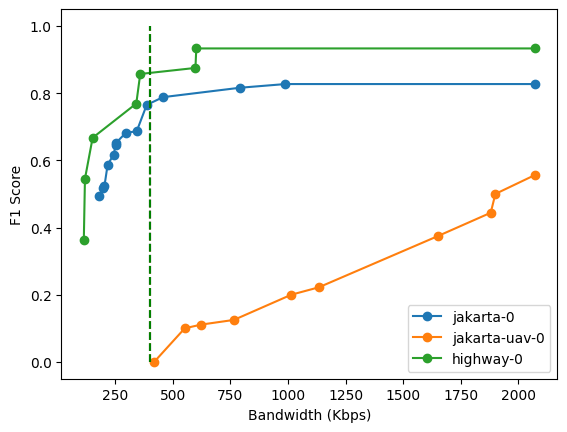

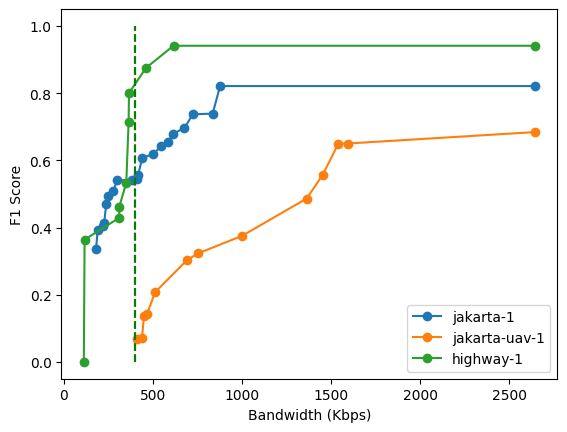

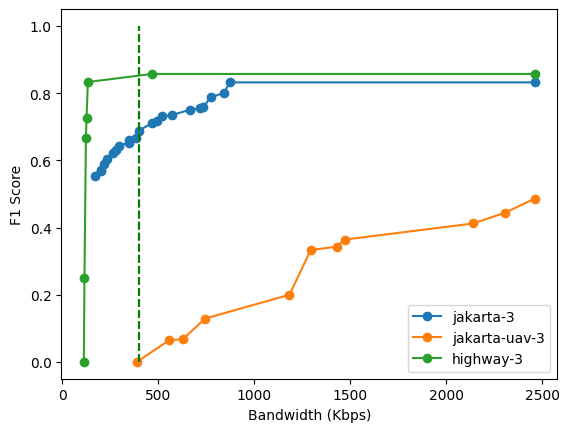

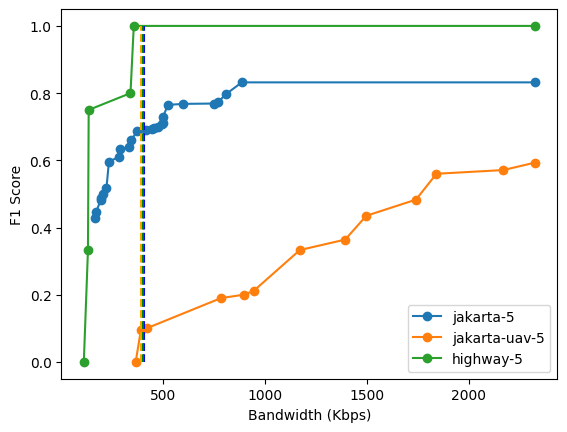

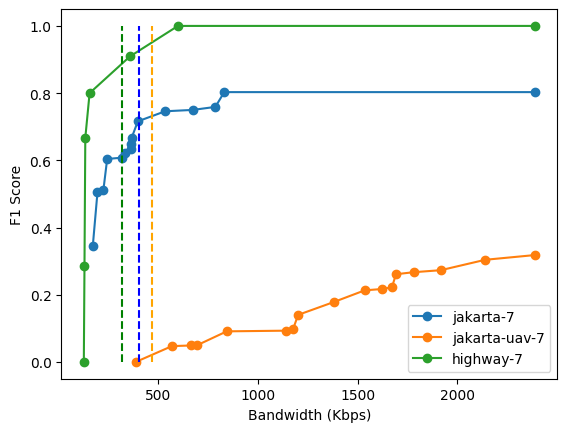

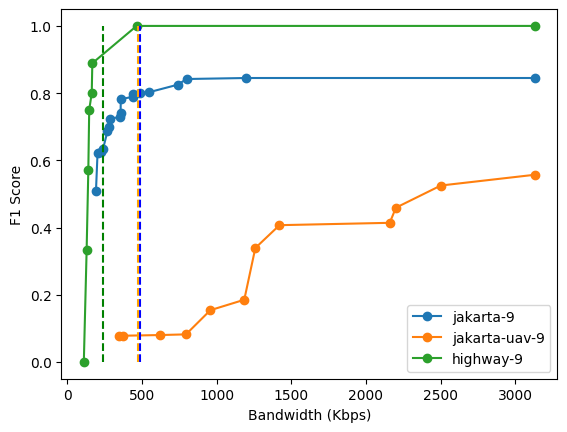

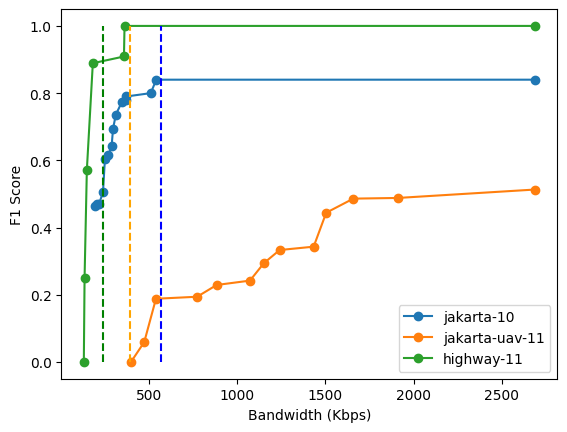

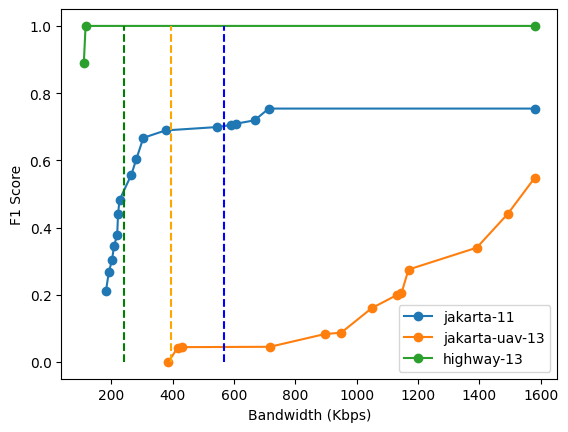

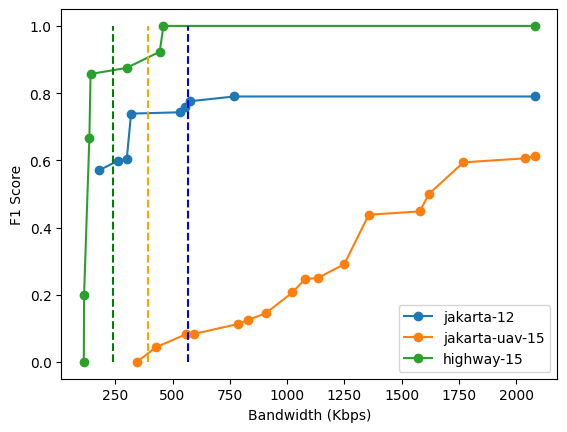

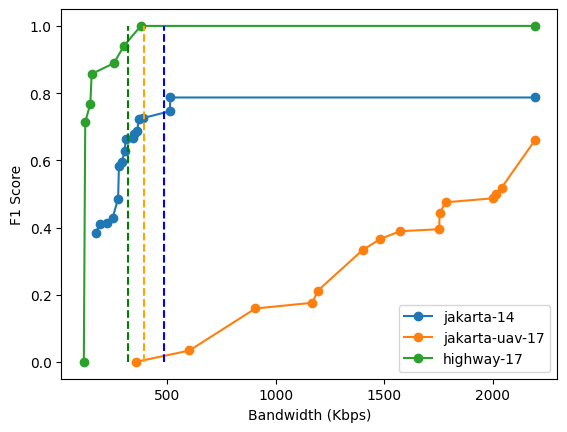

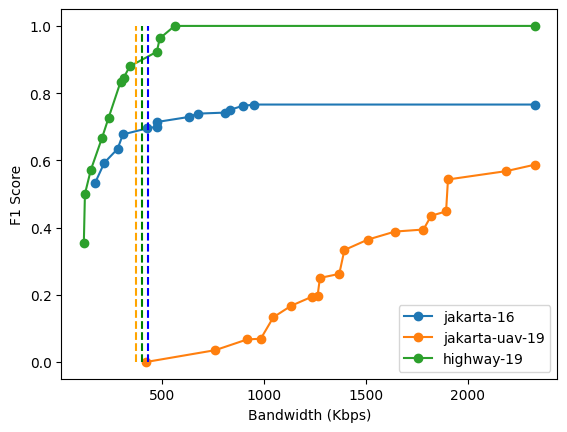

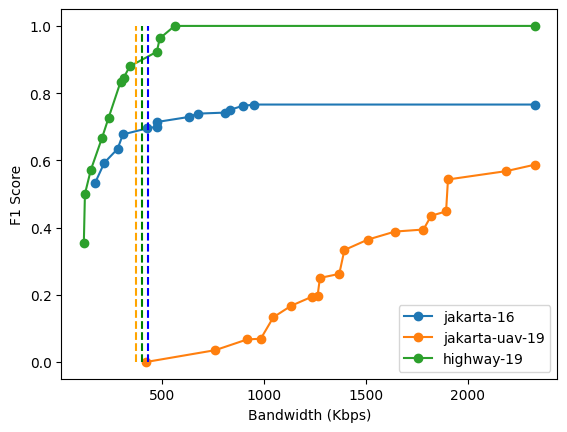

In [49]:
for i in range(len(log[1])):
    plot_profile_debug(i, *(log[k].loc[i, "fid"]//5 for k in range(1,4)))